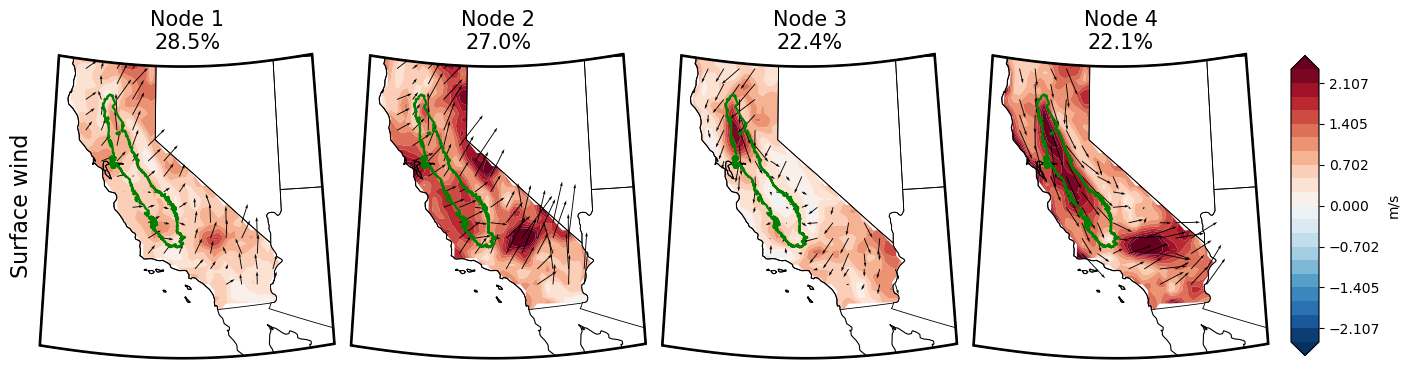

In [5]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib as mpl
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import geopandas as gpd
import regionmask
from cartopy.io import shapereader
from matplotlib.path import Path
from matplotlib.patches import PathPatch
from somoclu import Somoclu

# -------------------- FILES --------------------
Z500_FILE   = "z_dust1.nc"
WS_COMP     = "son_dusty_wind.nc"
U_COMP      = "son_dusty_u.nc"
V_COMP      = "son_dusty_v.nc"
WS_CLIM     = "clim_wind.nc"
U_CLIM      = "clim_u.nc"
V_CLIM      = "clim_v.nc"
CV_SHP      = "central_valley_alluvial_boundary_usgs.shp"

OUT_ANOM    = "node_WIND.png"

# -------------------- DOMAIN / STYLE --------------------
SOM_LON0, SOM_LON1 = -130, -105
SOM_LAT0, SOM_LAT1 =   30,   50
BOX_LON0, BOX_LON1 = -125.0, -112.0
BOX_LAT0, BOX_LAT1 =   31.0,   42.1

SOM_EPOCHS   = 1000
ROB_Q        = 98
QUIVER_STEP  = 3
QUIVER_SCALE = 25

# -------------------- HELPERS --------------------
def tname(ds):
    for k in ("date","time"):
        if k in ds.coords or k in ds.dims: return k
    raise KeyError("No 'valid_time' or 'time' coord.")

def rename_ll(da):
    if "lat" in da.dims: da = da.rename({"lat":"latitude"})
    if "lon" in da.dims: da = da.rename({"lon":"longitude"})
    return da

def fix_lon(da):
    if float(da.longitude.max()) > 180:
        da = da.assign_coords(longitude=((da.longitude+180)%360)-180).sortby("longitude")
    return da

def find_var(ds, candidates):
    for k in candidates:
        if k in ds.data_vars: return k
    for v in ds.data_vars:
        if any(k in v.lower() for k in candidates): return v
    return list(ds.data_vars)[0]

def build_frame(l0,l1,b0,b1, n=200, aT=0.28, aB=0.32):
    f=np.linspace(0,1,n)
    top   = np.c_[np.linspace(l0,l1,n), b1 - aT*np.sin(np.pi*f)]
    right = np.c_[[l1]*n, np.linspace(b1,b0,n)]
    bot   = np.c_[np.linspace(l1,l0,n), b0 - aB*np.sin(np.pi*f)]
    left  = np.c_[[l0]*n, np.linspace(b0,b1,n)]
    pts   = np.vstack([top,right,bot,left,top[:1]])
    codes = [Path.MOVETO] + [Path.LINETO]*(len(pts)-2) + [Path.CLOSEPOLY]
    return Path(pts, codes)

def clip_to_frame(ax, path):
    ax.set_boundary(path, transform=ccrs.PlateCarree())
    ax.patch.set_facecolor("none")
    ax.add_patch(PathPatch(path, transform=ccrs.PlateCarree(),
                           facecolor="none", edgecolor="black",
                           linewidth=3, zorder=10))

def crop_rect(da):
    return da.where((da.latitude>=BOX_LAT0)&(da.latitude<=BOX_LAT1)&
                    (da.longitude>=BOX_LON0)&(da.longitude<=BOX_LON1), drop=True)

def mask_CA(da):
    ne = shapereader.natural_earth("50m","cultural","admin_1_states_provinces")
    states = gpd.read_file(ne).to_crs(4326)
    ca = states.query("name=='California' and adm0_a3=='USA'").geometry.union_all()
    g  = gpd.GeoDataFrame(geometry=[ca.buffer(0.05)], crs=4326)
    m  = regionmask.mask_geopandas(g, da.longitude, da.latitude)
    return da.where(~np.isnan(m)), g   # return the polygon g as well if needed

def md_group_mean(da, t):
    md = xr.DataArray(da[t].dt.strftime("%m-%d").values, dims=[t], name="md")
    return da.groupby(md).mean(t)  # → dim 'md'

def node_mean(da, mask_bool):
    tn = [d for d in da.dims if d in ("time","date")][0]
    idx = np.where(mask_bool)[0]
    if idx.size == 0:
        return np.full((da.sizes["latitude"], da.sizes["longitude"]), np.nan)
    return da.isel({tn: idx}).mean(tn, skipna=True).values

# -------------------- 1) SOM on Z500 --------------------
dsz = xr.open_dataset(Z500_FILE); tz=tname(dsz)
z = rename_ll(fix_lon(dsz["z"]))
if "pressure_level" in z.dims: z = z.sel(pressure_level=500)
z = z.sel({tz: z[tz].dt.month.isin([9,10,11])})
z = z.where((z.latitude>=SOM_LAT0)&(z.latitude<=SOM_LAT1)&
            (z.longitude>=SOM_LON0)&(z.longitude<=SOM_LON1), drop=True)

A = z.values; nt, ny, nx = A.shape
som = Somoclu(2,2, maptype="planar", initialization="pca")
np.random.seed(0)
som.train(A.reshape(nt, ny*nx), epochs=SOM_EPOCHS)
labels_all = som.bmus[:,0]*2 + som.bmus[:,1]
times_all  = z[tz].values
freqs = np.array([(labels_all==i).mean()*100 for i in range(4)])
order = np.argsort(-freqs)  # most→least

# -------------------- 2) Load composites/clims --------------------
dsc_ws = xr.open_dataset(WS_COMP); dsc_u = xr.open_dataset(U_COMP); dsc_v = xr.open_dataset(V_COMP)
wsC = rename_ll(fix_lon(dsc_ws[find_var(dsc_ws,["ws","speed","wind","sfcwind","ws10"])]))
uC  = rename_ll(fix_lon(dsc_u[ find_var(dsc_u, ["u10","uas","u"]) ]))
vC  = rename_ll(fix_lon(dsc_v[ find_var(dsc_v, ["v10","vas","v"]) ]))
tc_ws = tname(dsc_ws); tc_u = tname(dsc_u); tc_v = tname(dsc_v)

dsk_ws = xr.open_dataset(WS_CLIM); dsk_u = xr.open_dataset(U_CLIM); dsk_v = xr.open_dataset(V_CLIM)
wsK = rename_ll(fix_lon(dsk_ws[find_var(dsk_ws,["ws","speed","wind","sfcwind","ws10"])]))
uK  = rename_ll(fix_lon(dsk_u[ find_var(dsk_u, ["u10","uas","u"]) ]))
vK  = rename_ll(fix_lon(dsk_v[ find_var(dsk_v, ["v10","vas","v"]) ]))
tk_ws = tname(dsk_ws); tk_u = tname(dsk_u); tk_v = tname(dsk_v)

# Align lon/lat & SON only
wsK, wsC = xr.align(wsK, wsC, join="inner")
uK,  uC  = xr.align(uK,  uC,  join="inner")
vK,  vC  = xr.align(vK,  vC,  join="inner")
wsC = wsC.sel({tc_ws: wsC[tc_ws].dt.month.isin([9,10,11])})
uC  = uC.sel({tc_u:  uC[tc_u].dt.month.isin([9,10,11])})
vC  = vC.sel({tc_v:  vC[tc_v].dt.month.isin([9,10,11])})

# Common times with labels
common = np.intersect1d(np.intersect1d(wsC[tc_ws].values, uC[tc_u].values),
                        np.intersect1d(vC[tc_v].values, times_all))
wsC = wsC.sel({tc_ws: wsC[tc_ws].isin(common)})
uC  = uC.sel({tc_u:  uC[tc_u].isin(common)})
vC  = vC.sel({tc_v:  vC[tc_v].isin(common)})

# Reorder labels to wsC time sequence
labels_lookup = {t: lab for t, lab in zip(times_all, labels_all)}
labels = np.array([labels_lookup[t] for t in wsC[tc_ws].values])

# Shaded wind → CA mask; quiver grid (cropped only)
wsC_sh, g_ca = mask_CA(crop_rect(wsC))
wsK_sh, _    = mask_CA(crop_rect(wsK))
uC_q = crop_rect(uC);  vC_q = crop_rect(vC)
uK_q = crop_rect(uK);  vK_q = crop_rect(vK)

# Build CA mask ON THE QUIVER GRID and keep as boolean
ca_mask_q = regionmask.mask_geopandas(g_ca, uC_q.longitude, uC_q.latitude)
inside_q = ~np.isnan(ca_mask_q)  # True inside California polygon

# Climatology by month–day
clim_md_ws_sh = md_group_mean(wsK_sh, tk_ws)
clim_md_u_q   = md_group_mean(uK_q,  tk_u)
clim_md_v_q   = md_group_mean(vK_q,  tk_v)
md_all = wsC[tc_ws].dt.strftime("%m-%d").values

# -------------------- 3) Node ANOMALIES --------------------
ny, nx  = wsC_sh.sizes["latitude"], wsC_sh.sizes["longitude"]
nyq, nxq = uC_q.sizes["latitude"],  uC_q.sizes["longitude"]

ws_anom_nodes, u_anom_q_nodes, v_anom_q_nodes = [], [], []
for n in range(4):
    m = (labels == n)
    md_n = md_all[m]
    if md_n.size == 0:
        ws_anom_nodes.append(np.full((ny,nx), np.nan))
        u_anom_q_nodes.append(np.full((nyq,nxq), np.nan))
        v_anom_q_nodes.append(np.full((nyq,nxq), np.nan))
        continue

    ws_mean_n = node_mean(wsC_sh, m)
    ws_clim_n = clim_md_ws_sh.sel(md=md_n).mean("md", skipna=True).values
    ws_anom_nodes.append(ws_mean_n - ws_clim_n)

    u_mean_q = node_mean(uC_q, m)
    v_mean_q = node_mean(vC_q, m)
    u_cl = clim_md_u_q.sel(md=md_n).mean("md", skipna=True).values
    v_cl = clim_md_v_q.sel(md=md_n).mean("md", skipna=True).values
    u_anom_q_nodes.append(u_mean_q - u_cl)
    v_anom_q_nodes.append(v_mean_q - v_cl)

# Order by frequency
order = np.argsort(-freqs)
freq_sorted    = [freqs[i]            for i in order]
ws_anom_sorted = [ws_anom_nodes[i]    for i in order]
u_anom_sorted  = [u_anom_q_nodes[i]   for i in order]
v_anom_sorted  = [v_anom_q_nodes[i]   for i in order]

# Grids
LON_sh, LAT_sh = np.meshgrid(wsC_sh.longitude.values, wsC_sh.latitude.values)
LON_q,  LAT_q  = np.meshgrid(uC_q.longitude.values,  uC_q.latitude.values)

# -------------------- 4) PLOT: ANOMALY ONLY, QUIVERS INSIDE CA --------------------
cv_gdf = gpd.read_file(CV_SHP).to_crs(4326)
frame = build_frame(BOX_LON0,BOX_LON1,BOX_LAT0,BOX_LAT1)
proj = ccrs.LambertConformal(central_longitude=-119, central_latitude=37,
                             standard_parallels=(33,45))

fig, axes = plt.subplots(1,4, figsize=(14,6), subplot_kw={"projection": proj})
plt.tight_layout(rect=[0.08,0.02,0.98,1.00])

arr = np.stack(ws_anom_sorted, axis=0)
rob  = np.nanpercentile(np.abs(arr), ROB_Q)
vlim = float(max(rob, 0.5))
levels = np.linspace(-vlim, vlim, 21)
cmap = mpl.colormaps["RdBu_r"].copy()
cmap.set_bad(cmap(0)); cmap.set_under(cmap(0))
cf_last = None

for i, ax in enumerate(axes):
    clip_to_frame(ax, frame)
    ax.set_extent([BOX_LON0, BOX_LON1, BOX_LAT0, BOX_LAT1], crs=ccrs.PlateCarree())

    # shaded anomalies (masked to CA)
    cf_last = ax.contourf(LON_sh, LAT_sh, np.ma.masked_invalid(ws_anom_sorted[i]),
                          levels=levels, cmap=cmap, extend="both",
                          transform=ccrs.PlateCarree(), antialiased=True)

    # --- quivers: HARD MASK outside CA (set NaN) ---
    U = u_anom_sorted[i].copy()
    V = v_anom_sorted[i].copy()
    # mask outside CA or non-finite values
    outside = (~inside_q.values) | (~np.isfinite(U)) | (~np.isfinite(V))
    U[outside] = np.nan
    V[outside] = np.nan

    Uq = U[::QUIVER_STEP, ::QUIVER_STEP]
    Vq = V[::QUIVER_STEP, ::QUIVER_STEP]
    Xq = LON_q[::QUIVER_STEP, ::QUIVER_STEP]
    Yq = LAT_q[::QUIVER_STEP, ::QUIVER_STEP]

    ax.quiver(Xq, Yq, Uq, Vq, transform=ccrs.PlateCarree(),
              scale=QUIVER_SCALE, width=0.003, regrid_shape=20, zorder=7)

    ax.add_feature(cfeature.COASTLINE.with_scale("50m"), linewidth=0.8, zorder=6)
    ax.add_feature(cfeature.STATES.with_scale("50m"),  linewidth=0.6, zorder=6)
    ax.add_geometries(cv_gdf.geometry, crs=ccrs.PlateCarree(),
                      edgecolor="green", facecolor="none", linewidth=1.6, zorder=8)
    ax.set_title(f"Node {i+1}\n{freq_sorted[i]:.1f}%", fontsize=15, pad=3)

fig.supylabel("Surface wind", x=0.07, fontsize=16)
cax = fig.add_axes([0.985, 0.25, 0.02, 0.5])
cb  = fig.colorbar(cf_last, cax=cax, orientation="vertical")
cb.set_label("m/s")
fig.savefig(OUT_ANOM, dpi=500, bbox_inches="tight")
plt.show()


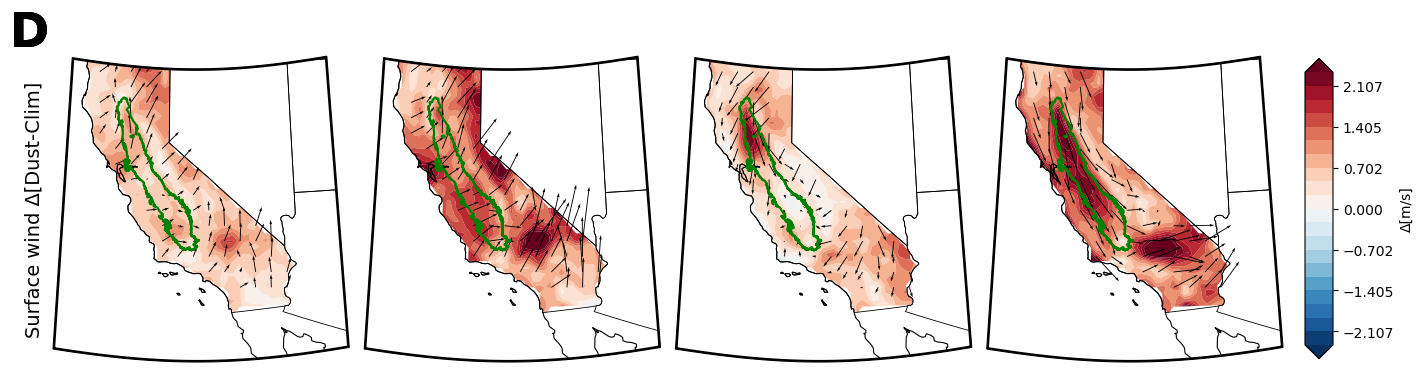

In [17]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib as mpl
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import geopandas as gpd
import regionmask
from cartopy.io import shapereader
from matplotlib.path import Path
from matplotlib.patches import PathPatch
from somoclu import Somoclu

# -------------------- FILES --------------------
Z500_FILE   = "z_dust1.nc"
WS_COMP     = "son_dusty_wind.nc"
U_COMP      = "son_dusty_u.nc"
V_COMP      = "son_dusty_v.nc"
WS_CLIM     = "clim_wind.nc"
U_CLIM      = "clim_u.nc"
V_CLIM      = "clim_v.nc"
CV_SHP      = "central_valley_alluvial_boundary_usgs.shp"

OUT_ANOM    = "anomaly_wind.png"

# -------------------- DOMAIN / STYLE --------------------
SOM_LON0, SOM_LON1 = -130, -105
SOM_LAT0, SOM_LAT1 =   30,   50
BOX_LON0, BOX_LON1 = -125.0, -112.0
BOX_LAT0, BOX_LAT1 =   31.0,   42.1

SOM_EPOCHS   = 1000
ROB_Q        = 98
QUIVER_STEP  = 3
QUIVER_SCALE = 25

# -------------------- HELPERS --------------------
def tname(ds):
    for k in ("date","time"):
        if k in ds.coords or k in ds.dims: return k
    raise KeyError("No 'valid_time' or 'time' coord.")

def rename_ll(da):
    if "lat" in da.dims: da = da.rename({"lat":"latitude"})
    if "lon" in da.dims: da = da.rename({"lon":"longitude"})
    return da

def fix_lon(da):
    if float(da.longitude.max()) > 180:
        da = da.assign_coords(longitude=((da.longitude+180)%360)-180).sortby("longitude")
    return da

def find_var(ds, candidates):
    for k in candidates:
        if k in ds.data_vars: return k
    for v in ds.data_vars:
        if any(k in v.lower() for k in candidates): return v
    return list(ds.data_vars)[0]

def build_frame(l0,l1,b0,b1, n=200, aT=0.28, aB=0.32):
    f=np.linspace(0,1,n)
    top   = np.c_[np.linspace(l0,l1,n), b1 - aT*np.sin(np.pi*f)]
    right = np.c_[[l1]*n, np.linspace(b1,b0,n)]
    bot   = np.c_[np.linspace(l1,l0,n), b0 - aB*np.sin(np.pi*f)]
    left  = np.c_[[l0]*n, np.linspace(b0,b1,n)]
    pts   = np.vstack([top,right,bot,left,top[:1]])
    codes = [Path.MOVETO] + [Path.LINETO]*(len(pts)-2) + [Path.CLOSEPOLY]
    return Path(pts, codes)

def clip_to_frame(ax, path):
    ax.set_boundary(path, transform=ccrs.PlateCarree())
    ax.patch.set_facecolor("none")
    ax.add_patch(PathPatch(path, transform=ccrs.PlateCarree(),
                           facecolor="none", edgecolor="black",
                           linewidth=3, zorder=10))

def crop_rect(da):
    return da.where((da.latitude>=BOX_LAT0)&(da.latitude<=BOX_LAT1)&
                    (da.longitude>=BOX_LON0)&(da.longitude<=BOX_LON1), drop=True)

def mask_CA(da):
    ne = shapereader.natural_earth("50m","cultural","admin_1_states_provinces")
    states = gpd.read_file(ne).to_crs(4326)
    ca = states.query("name=='California' and adm0_a3=='USA'").geometry.union_all()
    g  = gpd.GeoDataFrame(geometry=[ca.buffer(0.05)], crs=4326)
    m  = regionmask.mask_geopandas(g, da.longitude, da.latitude)
    return da.where(~np.isnan(m)), g   # return the polygon g as well if needed

def md_group_mean(da, t):
    md = xr.DataArray(da[t].dt.strftime("%m-%d").values, dims=[t], name="md")
    return da.groupby(md).mean(t)  # → dim 'md'

def node_mean(da, mask_bool):
    tn = [d for d in da.dims if d in ("time","date")][0]
    idx = np.where(mask_bool)[0]
    if idx.size == 0:
        return np.full((da.sizes["latitude"], da.sizes["longitude"]), np.nan)
    return da.isel({tn: idx}).mean(tn, skipna=True).values

# -------------------- 1) SOM on Z500 --------------------
dsz = xr.open_dataset(Z500_FILE); tz=tname(dsz)
z = rename_ll(fix_lon(dsz["z"]))
if "pressure_level" in z.dims: z = z.sel(pressure_level=500)
z = z.sel({tz: z[tz].dt.month.isin([9,10,11])})
z = z.where((z.latitude>=SOM_LAT0)&(z.latitude<=SOM_LAT1)&
            (z.longitude>=SOM_LON0)&(z.longitude<=SOM_LON1), drop=True)

A = z.values; nt, ny, nx = A.shape
som = Somoclu(2,2, maptype="planar", initialization="pca")
np.random.seed(777)
som.train(A.reshape(nt, ny*nx), epochs=SOM_EPOCHS)
labels_all = som.bmus[:,0]*2 + som.bmus[:,1]
times_all  = z[tz].values
freqs = np.array([(labels_all==i).mean()*100 for i in range(4)])
order = np.argsort(-freqs)  # most→least

# -------------------- 2) Load composites/clims --------------------
dsc_ws = xr.open_dataset(WS_COMP); dsc_u = xr.open_dataset(U_COMP); dsc_v = xr.open_dataset(V_COMP)
wsC = rename_ll(fix_lon(dsc_ws[find_var(dsc_ws,["ws","speed","wind","sfcwind","ws10"])]))
uC  = rename_ll(fix_lon(dsc_u[ find_var(dsc_u, ["u10","uas","u"]) ]))
vC  = rename_ll(fix_lon(dsc_v[ find_var(dsc_v, ["v10","vas","v"]) ]))
tc_ws = tname(dsc_ws); tc_u = tname(dsc_u); tc_v = tname(dsc_v)

dsk_ws = xr.open_dataset(WS_CLIM); dsk_u = xr.open_dataset(U_CLIM); dsk_v = xr.open_dataset(V_CLIM)
wsK = rename_ll(fix_lon(dsk_ws[find_var(dsk_ws,["ws","speed","wind","sfcwind","ws10"])]))
uK  = rename_ll(fix_lon(dsk_u[ find_var(dsk_u, ["u10","uas","u"]) ]))
vK  = rename_ll(fix_lon(dsk_v[ find_var(dsk_v, ["v10","vas","v"]) ]))
tk_ws = tname(dsk_ws); tk_u = tname(dsk_u); tk_v = tname(dsk_v)

# Align lon/lat & SON only
wsK, wsC = xr.align(wsK, wsC, join="inner")
uK,  uC  = xr.align(uK,  uC,  join="inner")
vK,  vC  = xr.align(vK,  vC,  join="inner")
wsC = wsC.sel({tc_ws: wsC[tc_ws].dt.month.isin([9,10,11])})
uC  = uC.sel({tc_u:  uC[tc_u].dt.month.isin([9,10,11])})
vC  = vC.sel({tc_v:  vC[tc_v].dt.month.isin([9,10,11])})

# Common times with labels
common = np.intersect1d(np.intersect1d(wsC[tc_ws].values, uC[tc_u].values),
                        np.intersect1d(vC[tc_v].values, times_all))
wsC = wsC.sel({tc_ws: wsC[tc_ws].isin(common)})
uC  = uC.sel({tc_u:  uC[tc_u].isin(common)})
vC  = vC.sel({tc_v:  vC[tc_v].isin(common)})

# Reorder labels to wsC time sequence
labels_lookup = {t: lab for t, lab in zip(times_all, labels_all)}
labels = np.array([labels_lookup[t] for t in wsC[tc_ws].values])

# Shaded wind → CA mask; quiver grid (cropped only)
wsC_sh, g_ca = mask_CA(crop_rect(wsC))
wsK_sh, _    = mask_CA(crop_rect(wsK))
uC_q = crop_rect(uC);  vC_q = crop_rect(vC)
uK_q = crop_rect(uK);  vK_q = crop_rect(vK)

# Build CA mask ON THE QUIVER GRID and keep as boolean
ca_mask_q = regionmask.mask_geopandas(g_ca, uC_q.longitude, uC_q.latitude)
inside_q = ~np.isnan(ca_mask_q)  # True inside California polygon

# Climatology by month–day
clim_md_ws_sh = md_group_mean(wsK_sh, tk_ws)
clim_md_u_q   = md_group_mean(uK_q,  tk_u)
clim_md_v_q   = md_group_mean(vK_q,  tk_v)
md_all = wsC[tc_ws].dt.strftime("%m-%d").values

# -------------------- 3) Node ANOMALIES --------------------
ny, nx  = wsC_sh.sizes["latitude"], wsC_sh.sizes["longitude"]
nyq, nxq = uC_q.sizes["latitude"],  uC_q.sizes["longitude"]

ws_anom_nodes, u_anom_q_nodes, v_anom_q_nodes = [], [], []
for n in range(4):
    m = (labels == n)
    md_n = md_all[m]
    if md_n.size == 0:
        ws_anom_nodes.append(np.full((ny,nx), np.nan))
        u_anom_q_nodes.append(np.full((nyq,nxq), np.nan))
        v_anom_q_nodes.append(np.full((nyq,nxq), np.nan))
        continue

    ws_mean_n = node_mean(wsC_sh, m)
    ws_clim_n = clim_md_ws_sh.sel(md=md_n).mean("md", skipna=True).values
    ws_anom_nodes.append(ws_mean_n - ws_clim_n)

    u_mean_q = node_mean(uC_q, m)
    v_mean_q = node_mean(vC_q, m)
    u_cl = clim_md_u_q.sel(md=md_n).mean("md", skipna=True).values
    v_cl = clim_md_v_q.sel(md=md_n).mean("md", skipna=True).values
    u_anom_q_nodes.append(u_mean_q - u_cl)
    v_anom_q_nodes.append(v_mean_q - v_cl)

# Order by frequency
order = np.argsort(-freqs)
freq_sorted    = [freqs[i]            for i in order]
ws_anom_sorted = [ws_anom_nodes[i]    for i in order]
u_anom_sorted  = [u_anom_q_nodes[i]   for i in order]
v_anom_sorted  = [v_anom_q_nodes[i]   for i in order]

# Grids
LON_sh, LAT_sh = np.meshgrid(wsC_sh.longitude.values, wsC_sh.latitude.values)
LON_q,  LAT_q  = np.meshgrid(uC_q.longitude.values,  uC_q.latitude.values)

# -------------------- 4) PLOT: ANOMALY ONLY, QUIVERS INSIDE CA --------------------
cv_gdf = gpd.read_file(CV_SHP).to_crs(4326)
frame = build_frame(BOX_LON0,BOX_LON1,BOX_LAT0,BOX_LAT1)
proj = ccrs.LambertConformal(central_longitude=-119, central_latitude=37,
                             standard_parallels=(33,45))

fig, axes = plt.subplots(1,4, figsize=(14,6), subplot_kw={"projection": proj})
plt.tight_layout(rect=[0.08,0.02,0.98,1.00])

arr = np.stack(ws_anom_sorted, axis=0)
rob  = np.nanpercentile(np.abs(arr), ROB_Q)
vlim = float(max(rob, 0.5))
levels = np.linspace(-vlim, vlim, 21)
cmap = mpl.colormaps["RdBu_r"].copy()
cmap.set_bad(cmap(0)); cmap.set_under(cmap(0))
cf_last = None

for i, ax in enumerate(axes):
    clip_to_frame(ax, frame)
    ax.set_extent([BOX_LON0, BOX_LON1, BOX_LAT0, BOX_LAT1], crs=ccrs.PlateCarree())

    # shaded anomalies (masked to CA)
    cf_last = ax.contourf(LON_sh, LAT_sh, np.ma.masked_invalid(ws_anom_sorted[i]),
                          levels=levels, cmap=cmap, extend="both",
                          transform=ccrs.PlateCarree(), antialiased=True)

    # --- quivers: HARD MASK outside CA (set NaN) ---
    U = u_anom_sorted[i].copy()
    V = v_anom_sorted[i].copy()
    # mask outside CA or non-finite values
    outside = (~inside_q.values) | (~np.isfinite(U)) | (~np.isfinite(V))
    U[outside] = np.nan
    V[outside] = np.nan

    Uq = U[::QUIVER_STEP, ::QUIVER_STEP]
    Vq = V[::QUIVER_STEP, ::QUIVER_STEP]
    Xq = LON_q[::QUIVER_STEP, ::QUIVER_STEP]
    Yq = LAT_q[::QUIVER_STEP, ::QUIVER_STEP]

    ax.quiver(Xq, Yq, Uq, Vq, transform=ccrs.PlateCarree(),
              scale=QUIVER_SCALE, width=0.003, regrid_shape=20, zorder=7)

    ax.add_feature(cfeature.COASTLINE.with_scale("50m"), linewidth=0.8, zorder=6)
    ax.add_feature(cfeature.STATES.with_scale("50m"),  linewidth=0.6, zorder=6)
    ax.add_geometries(cv_gdf.geometry, crs=ccrs.PlateCarree(),
                      edgecolor="green", facecolor="none", linewidth=1.6, zorder=8)
    #ax.set_title(f"Node {i+1}\n{freq_sorted[i]:.1f}%", fontsize=15, pad=3)

    ax0=axes.flat[0]
    
    b = ax0.get_position()
    fig.text(0.06, b.y1,"D", ha="left",va="bottom", fontsize=34,fontweight="bold",
             fontfamily="sans-serif",transform=fig.transFigure)

fig.supylabel("Surface wind Δ[Dust-Clim]", x=0.07, fontsize=14)
cax = fig.add_axes([0.985, 0.25, 0.02, 0.5])
cb  = fig.colorbar(cf_last, cax=cax, orientation="vertical")
cb.set_label("Δ[m/s]")
fig.savefig(OUT_ANOM, dpi=500, bbox_inches="tight")
plt.show()


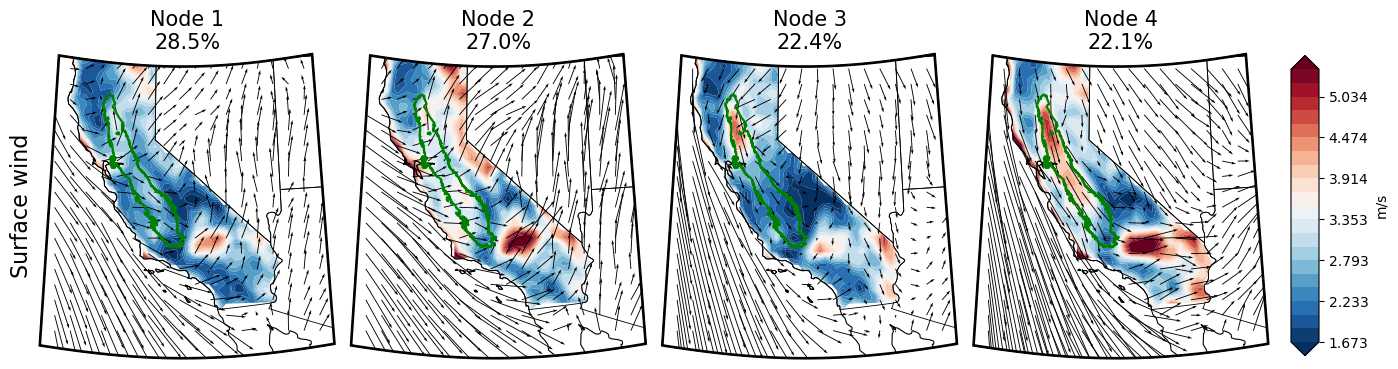

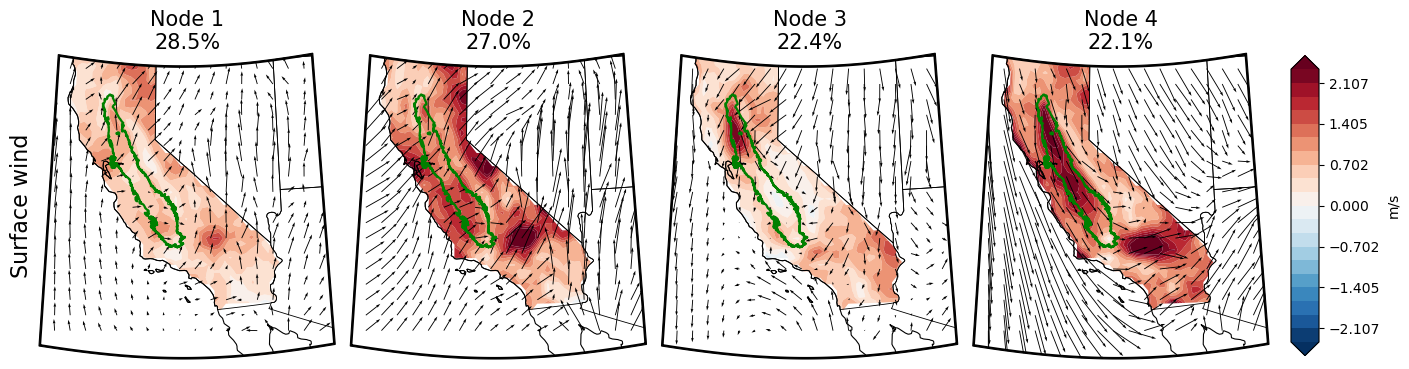

In [11]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib as mpl
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import geopandas as gpd
import regionmask
from cartopy.io import shapereader
from matplotlib.path import Path
from matplotlib.patches import PathPatch
from somoclu import Somoclu


Z500_FILE   = "z_dust1.nc"
WS_COMP     = "son_dusty_wind.nc"
U_COMP      = "son_dusty_u.nc"
V_COMP      = "son_dusty_v.nc"
WS_CLIM     = "clim_wind.nc"
U_CLIM      = "clim_u.nc"
V_CLIM      = "clim_v.nc"
CV_SHP      = "central_valley_alluvial_boundary_usgs.shp"

# ===================== FILES =====================
#Z500_FILE   = "z_dust1.nc"
#WS_COMP     = "son_dusty.nc"
#U_COMP      = "u_son_dusty.nc"
#V_COMP      = "v_son_dusty.nc"
#WS_CLIM     = "clim_wind.nc"
#U_CLIM      = "clim_u.nc"
#V_CLIM      = "clim_v.nc"
#CV_SHP      = "central_valley_alluvial_boundary_usgs.shp"

OUT_MEAN    = "wind_mean_by_node.png"
OUT_ANOM    = "wind_anom_by_node.png"

# ===================== DOMAINS/STYLE =====================
SOM_LON0, SOM_LON1 = -130, -105
SOM_LAT0, SOM_LAT1 =   30,   50

BOX_LON0, BOX_LON1 = -125.0, -112.0
BOX_LAT0, BOX_LAT1 =   31.0,   42.1

SOM_EPOCHS   = 1000
ROB_Q        = 98
QUIVER_STEP  = 3
QUIVER_SCALE = 30

# ===================== HELPERS =====================
def tname(ds):
    for k in ("date","time"):
        if k in ds.coords or k in ds.dims: return k
    raise KeyError("No 'valid_time' or 'date' coord.")

def rename_ll(da):
    if "lat" in da.dims: da = da.rename({"lat":"latitude"})
    if "lon" in da.dims: da = da.rename({"lon":"longitude"})
    return da

def fix_lon(da):
    if float(da.longitude.max()) > 180:
        da = da.assign_coords(longitude=((da.longitude+180)%360)-180).sortby("longitude")
    return da

def find_var(ds, candidates):
    for k in candidates:
        if k in ds.data_vars: return k
    for v in ds.data_vars:
        if any(k in v.lower() for k in candidates): return v
    return list(ds.data_vars)[0]

def build_frame(l0,l1,b0,b1, n=200, aT=0.28, aB=0.32):
    f=np.linspace(0,1,n)
    top   = np.c_[np.linspace(l0,l1,n), b1 - aT*np.sin(np.pi*f)]
    right = np.c_[[l1]*n, np.linspace(b1,b0,n)]
    bot   = np.c_[np.linspace(l1,l0,n), b0 - aB*np.sin(np.pi*f)]
    left  = np.c_[[l0]*n, np.linspace(b0,b1,n)]
    pts   = np.vstack([top,right,bot,left,top[:1]])
    codes = [Path.MOVETO] + [Path.LINETO]*(len(pts)-2) + [Path.CLOSEPOLY]
    return Path(pts, codes)

def clip_to_frame(ax, path):
    ax.set_boundary(path, transform=ccrs.PlateCarree())
    ax.patch.set_facecolor("none")
    ax.add_patch(PathPatch(path, transform=ccrs.PlateCarree(),
                           facecolor="none", edgecolor="black",
                           linewidth=3, zorder=10))

def crop_rect(da):
    return da.where((da.latitude>=BOX_LAT0)&(da.latitude<=BOX_LAT1)&
                    (da.longitude>=BOX_LON0)&(da.longitude<=BOX_LON1), drop=True)

def mask_CA(da):
    ne = shapereader.natural_earth("50m","cultural","admin_1_states_provinces")
    states = gpd.read_file(ne).to_crs(4326)
    ca = states.query("name=='California' and adm0_a3=='USA'").geometry.union_all()
    g  = gpd.GeoDataFrame(geometry=[ca.buffer(0.05)], crs=4326)
    m  = regionmask.mask_geopandas(g, da.longitude, da.latitude)
    return da.where(~np.isnan(m))

def monthday_group_mean(da, t):
    md = xr.DataArray(da[t].dt.strftime("%m-%d").values, dims=[t], name="md")
    return da.groupby(md).mean(t)  # → dim 'md'

def node_mean_any(da, mask_bool):
    tn = [d for d in da.dims if d in ("date","date")][0]
    idx = np.where(mask_bool)[0]
    if idx.size == 0:
        return np.full((da.sizes["latitude"], da.sizes["longitude"]), np.nan)
    return da.isel({tn: idx}).mean(tn, skipna=True).values

# ===================== 1) SOM on Z500 =====================
dsz = xr.open_dataset(Z500_FILE); tz=tname(dsz)
z = rename_ll(fix_lon(dsz["z"]))
if "pressure_level" in z.dims: z = z.sel(pressure_level=500)
z = z.sel({tz: z[tz].dt.month.isin([9,10,11])})
z = z.where((z.latitude>=SOM_LAT0)&(z.latitude<=SOM_LAT1)&
            (z.longitude>=SOM_LON0)&(z.longitude<=SOM_LON1), drop=True)

A = z.values; nt, ny, nx = A.shape
som = Somoclu(2,2, maptype="planar", initialization="pca")
np.random.seed(0)
som.train(A.reshape(nt, ny*nx), epochs=SOM_EPOCHS)
labels_all = som.bmus[:,0]*2 + som.bmus[:,1]
times_all  = z[tz].values
freqs = np.array([(labels_all==i).mean()*100 for i in range(4)])
order_freq = np.argsort(-freqs)

# ===================== 2) Load ws/u/v + climatologies =====================
dsc_ws = xr.open_dataset(WS_COMP); dsc_u = xr.open_dataset(U_COMP); dsc_v = xr.open_dataset(V_COMP)
wsC = rename_ll(fix_lon(dsc_ws[find_var(dsc_ws,["ws","speed","wind","sfcwind","ws10"])]))
uC  = rename_ll(fix_lon(dsc_u[ find_var(dsc_u, ["u10","uas","u"]) ]))
vC  = rename_ll(fix_lon(dsc_v[ find_var(dsc_v, ["v10","vas","v"]) ]))
tc_ws = tname(dsc_ws); tc_u = tname(dsc_u); tc_v = tname(dsc_v)

dsk_ws = xr.open_dataset(WS_CLIM); dsk_u = xr.open_dataset(U_CLIM); dsk_v = xr.open_dataset(V_CLIM)
wsK = rename_ll(fix_lon(dsk_ws[find_var(dsk_ws,["ws","speed","wind","sfcwind","ws10"])]))
uK  = rename_ll(fix_lon(dsk_u[ find_var(dsk_u, ["u10","uas","u"]) ]))
vK  = rename_ll(fix_lon(dsk_v[ find_var(dsk_v, ["v10","vas","v"]) ]))
tk_ws = tname(dsk_ws); tk_u = tname(dsk_u); tk_v = tname(dsk_v)

# Align lon/lat
wsK, wsC = xr.align(wsK, wsC, join="inner")
uK,  uC  = xr.align(uK,  uC,  join="inner")
vK,  vC  = xr.align(vK,  vC,  join="inner")

# SON only
wsC = wsC.sel({tc_ws: wsC[tc_ws].dt.month.isin([9,10,11])})
uC  = uC.sel({tc_u:  uC[tc_u].dt.month.isin([9,10,11])})
vC  = vC.sel({tc_v:  vC[tc_v].dt.month.isin([9,10,11])})

# Common times with Z500 labels
common = np.intersect1d(np.intersect1d(wsC[tc_ws].values, uC[tc_u].values),
                        np.intersect1d(vC[tc_v].values, times_all))
wsC = wsC.sel({tc_ws: wsC[tc_ws].isin(common)})
uC  = uC.sel({tc_u:  uC[tc_u].isin(common)})
vC  = vC.sel({tc_v:  vC[tc_v].isin(common)})

# Align labels to wsC time order
labels_lookup = {t: lab for t, lab in zip(times_all, labels_all)}
labels = np.array([labels_lookup[t] for t in wsC[tc_ws].values])

# ==== Shaded vs Quiver fields ====
# Shaded wind (both figures use masked shading):
wsC_sh = mask_CA(crop_rect(wsC))
wsK_sh = mask_CA(crop_rect(wsK))

# Quivers:
# - Mean figure: unmasked (cropped only)
# - Anomaly figure: we’ll mask arrows to CA using a mask computed on this grid
uC_q = crop_rect(uC);  vC_q = crop_rect(vC)
uK_q = crop_rect(uK);  vK_q = crop_rect(vK)

# California mask on the QUIVER grid (1 = inside CA)
ne = shapereader.natural_earth("50m","cultural","admin_1_states_provinces")
states = gpd.read_file(ne).to_crs(4326)
ca = states.query("name=='California' and adm0_a3=='USA'").geometry.union_all()
g  = gpd.GeoDataFrame(geometry=[ca.buffer(0.05)], crs=4326)
ca_mask_q = regionmask.mask_geopandas(g, uC_q.longitude, uC_q.latitude)
inside_q = ~np.isnan(ca_mask_q)   # True inside California polygon

# Climatology by month–day
clim_md_ws_sh = monthday_group_mean(wsK_sh, tk_ws)
clim_md_u_q   = monthday_group_mean(uK_q,  tk_u)
clim_md_v_q   = monthday_group_mean(vK_q,  tk_v)
md_all = wsC[tc_ws].dt.strftime("%m-%d").values

# ===================== 3) Node means & anomalies =====================
ny, nx  = wsC_sh.sizes["latitude"], wsC_sh.sizes["longitude"]
nyq, nxq = uC_q.sizes["latitude"],  uC_q.sizes["longitude"]

ws_mean_nodes, ws_anom_nodes = [], []
u_mean_q_nodes, v_mean_q_nodes = [], []
u_anom_q_nodes, v_anom_q_nodes = [], []

for n in range(4):
    m = (labels == n)

    # shaded wind (masked to CA)
    ws_mean_nodes.append(node_mean_any(wsC_sh, m))

    md_n = md_all[m]
    if md_n.size == 0:
        ws_anom_nodes.append(np.full((ny,nx), np.nan))
        u_anom_q_nodes.append(np.full((nyq,nxq), np.nan))
        v_anom_q_nodes.append(np.full((nyq,nxq), np.nan))
    else:
        ws_clim_n = clim_md_ws_sh.sel(md=md_n).mean("md", skipna=True).values
        ws_anom_nodes.append(ws_mean_nodes[-1] - ws_clim_n)

        u_cl = clim_md_u_q.sel(md=md_n).mean("md", skipna=True).values
        v_cl = clim_md_v_q.sel(md=md_n).mean("md", skipna=True).values
        # mean on cropped grid (for arrows)
        u_mean_q = node_mean_any(uC_q, m)
        v_mean_q = node_mean_any(vC_q, m)
        u_anom_q_nodes.append(u_mean_q - u_cl)
        v_anom_q_nodes.append(v_mean_q - v_cl)

    # store mean arrows too
    u_mean_q_nodes.append(node_mean_any(uC_q, m))
    v_mean_q_nodes.append(node_mean_any(vC_q, m))

# Order nodes by frequency
order = order_freq
freq_sorted     = [freqs[i]          for i in order]
ws_mean_sorted  = [ws_mean_nodes[i]  for i in order]
ws_anom_sorted  = [ws_anom_nodes[i]  for i in order]
u_mean_sorted_q = [u_mean_q_nodes[i] for i in order]
v_mean_sorted_q = [v_mean_q_nodes[i] for i in order]
u_anom_sorted_q = [u_anom_q_nodes[i] for i in order]
v_anom_sorted_q = [v_anom_q_nodes[i] for i in order]

# Grids
LON_sh, LAT_sh = np.meshgrid(wsC_sh.longitude.values, wsC_sh.latitude.values)   # shaded
LON_q,  LAT_q  = np.meshgrid(uC_q.longitude.values,  uC_q.latitude.values)      # quivers

# ===================== 4) Plot =====================
cv_gdf = gpd.read_file(CV_SHP).to_crs(4326)
frame = build_frame(BOX_LON0,BOX_LON1,BOX_LAT0,BOX_LAT1)
proj = ccrs.LambertConformal(central_longitude=-119, central_latitude=37,
                             standard_parallels=(33,45))

def plot_with_quivers(shaded_list, U_list, V_list, LON_s, LAT_s, title, out_png, is_anom):
    fig, axes = plt.subplots(1,4, figsize=(14,6), subplot_kw={"projection": proj})
    plt.tight_layout(rect=[0.08,0.02,0.98,1.00])

    arr = np.stack(shaded_list, axis=0)
    if is_anom:
        rob = np.nanpercentile(np.abs(arr), ROB_Q)
        vlim = float(max(rob, 0.5))
        levels = np.linspace(-vlim, vlim, 21)
        cmap = mpl.colormaps["RdBu_r"].copy()
        extend = "both"
    else:
        lo, hi = np.nanpercentile(arr, [2,98])
        if not np.isfinite(lo): lo = float(np.nanmin(arr))
        if not np.isfinite(hi): hi = float(np.nanmax(arr))
        if hi <= lo: hi = lo + 1e-6
        levels = np.linspace(lo, hi, 21)
        cmap = mpl.colormaps["RdBu_r"].copy()
        extend = "both"

    cmap.set_bad(cmap(0)); cmap.set_under(cmap(0))
    cf_last = None

    for i, ax in enumerate(axes):
        clip_to_frame(ax, frame)
        ax.set_extent([BOX_LON0, BOX_LON1, BOX_LAT0, BOX_LAT1], crs=ccrs.PlateCarree())

        # shaded wind (masked)
        cf_last = ax.contourf(LON_s, LAT_s, np.ma.masked_invalid(shaded_list[i]),
                              levels=levels, cmap=cmap, extend=extend,
                              transform=ccrs.PlateCarree(), antialiased=True)

        # quivers (mask outside CA only if anomaly plot)
        U = U_list[i]; V = V_list[i]
        base_mask = ~np.isfinite(U) | ~np.isfinite(V)
        if is_anom:
            # add outside-CA mask for anomaly arrows
            base_mask = base_mask | (~inside_q.values)
        Uq = np.ma.masked_array(U, mask=base_mask)[::QUIVER_STEP, ::QUIVER_STEP]
        Vq = np.ma.masked_array(V, mask=base_mask)[::QUIVER_STEP, ::QUIVER_STEP]
        Xq = LON_q[::QUIVER_STEP, ::QUIVER_STEP]
        Yq = LAT_q[::QUIVER_STEP, ::QUIVER_STEP]
        ax.quiver(Xq, Yq, Uq, Vq, transform=ccrs.PlateCarree(),
                  scale=QUIVER_SCALE, width=0.003, regrid_shape=20, zorder=7)

        ax.add_feature(cfeature.COASTLINE.with_scale("50m"), linewidth=0.8, zorder=6)
        ax.add_feature(cfeature.STATES.with_scale("50m"),  linewidth=0.6, zorder=6)
        ax.add_geometries(cv_gdf.geometry, crs=ccrs.PlateCarree(),
                          edgecolor="green", facecolor="none", linewidth=1.6, zorder=8)
        ax.set_title(f"Node {i+1}\n{freq_sorted[i]:.1f}%", fontsize=15, pad=3)

    fig.supylabel(title, x=0.07, fontsize=16)
    cax = fig.add_axes([0.985, 0.25, 0.02, 0.5])
    cb  = fig.colorbar(cf_last, cax=cax, orientation="vertical")
    cb.set_label("m/s")
    fig.savefig(out_png, dpi=500, bbox_inches="tight")
    plt.show()

# (A) MEAN — quivers unmasked (everywhere)
plot_with_quivers(ws_mean_sorted, u_mean_sorted_q, v_mean_sorted_q,
                  LON_sh, LAT_sh, "Surface wind", OUT_MEAN, is_anom=False)

# (B) ANOMALY — quivers masked to California only
plot_with_quivers(ws_anom_sorted, u_anom_sorted_q, v_anom_sorted_q,
                  LON_sh, LAT_sh, "Surface wind", OUT_ANOM, is_anom=True)


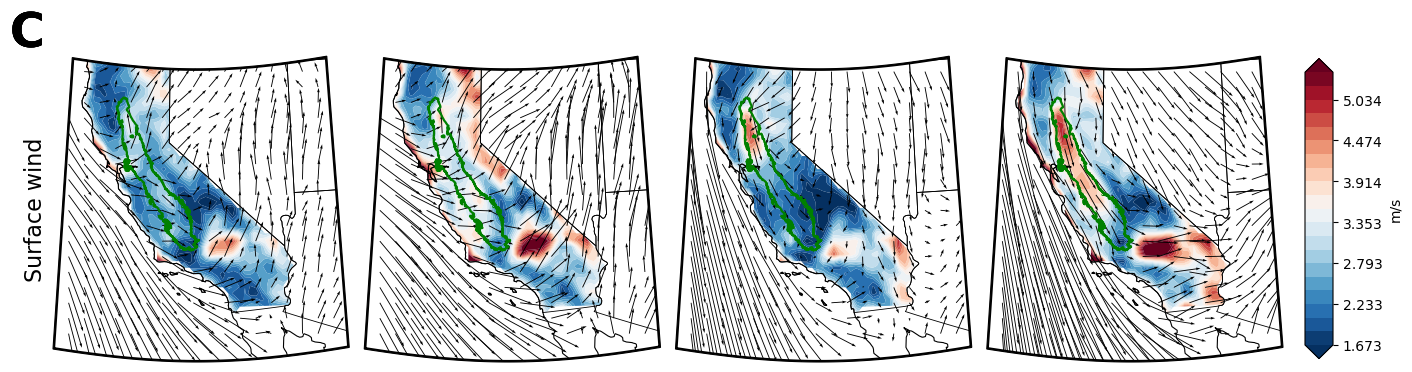

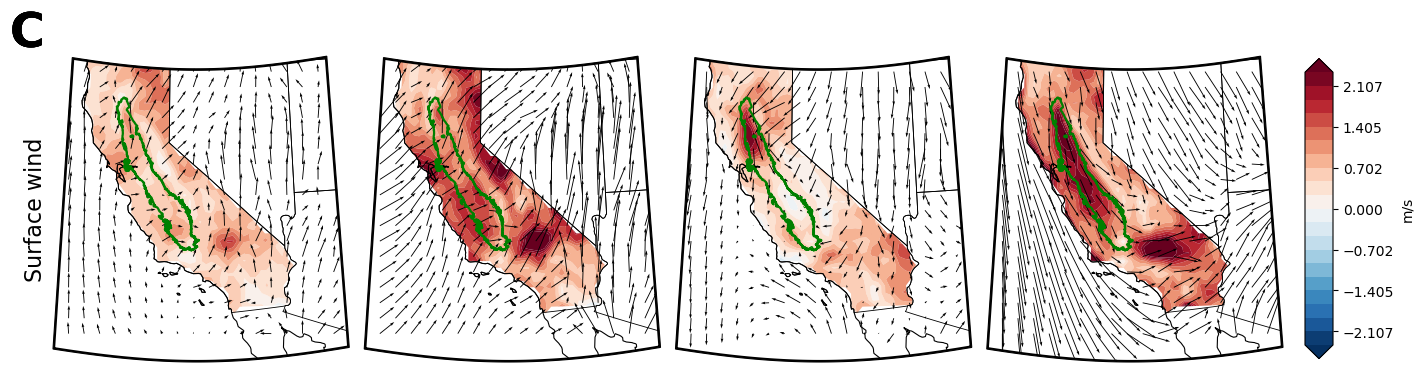

In [18]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib as mpl
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import geopandas as gpd
import regionmask
from cartopy.io import shapereader
from matplotlib.path import Path
from matplotlib.patches import PathPatch
from somoclu import Somoclu


Z500_FILE   = "z_dust1.nc"
WS_COMP     = "son_dusty_wind.nc"
U_COMP      = "son_dusty_u.nc"
V_COMP      = "son_dusty_v.nc"
WS_CLIM     = "clim_wind.nc"
U_CLIM      = "clim_u.nc"
V_CLIM      = "clim_v.nc"
CV_SHP      = "central_valley_alluvial_boundary_usgs.shp"

# ===================== FILES =====================
#Z500_FILE   = "z_dust1.nc"
#WS_COMP     = "son_dusty.nc"
#U_COMP      = "u_son_dusty.nc"
#V_COMP      = "v_son_dusty.nc"
#WS_CLIM     = "clim_wind.nc"
#U_CLIM      = "clim_u.nc"
#V_CLIM      = "clim_v.nc"
#CV_SHP      = "central_valley_alluvial_boundary_usgs.shp"

OUT_MEAN    = "wind_mean_by_node5.png"
OUT_ANOM    = "wind_anom_by_node5.png"

# ===================== DOMAINS/STYLE =====================
SOM_LON0, SOM_LON1 = -130, -105
SOM_LAT0, SOM_LAT1 =   30,   50

BOX_LON0, BOX_LON1 = -125.0, -112.0
BOX_LAT0, BOX_LAT1 =   31.0,   42.1

SOM_EPOCHS   = 1000
ROB_Q        = 98
QUIVER_STEP  = 3
QUIVER_SCALE = 30

# ===================== HELPERS =====================
def tname(ds):
    for k in ("date","time"):
        if k in ds.coords or k in ds.dims: return k
    raise KeyError("No 'valid_time' or 'date' coord.")

def rename_ll(da):
    if "lat" in da.dims: da = da.rename({"lat":"latitude"})
    if "lon" in da.dims: da = da.rename({"lon":"longitude"})
    return da

def fix_lon(da):
    if float(da.longitude.max()) > 180:
        da = da.assign_coords(longitude=((da.longitude+180)%360)-180).sortby("longitude")
    return da

def find_var(ds, candidates):
    for k in candidates:
        if k in ds.data_vars: return k
    for v in ds.data_vars:
        if any(k in v.lower() for k in candidates): return v
    return list(ds.data_vars)[0]

def build_frame(l0,l1,b0,b1, n=200, aT=0.28, aB=0.32):
    f=np.linspace(0,1,n)
    top   = np.c_[np.linspace(l0,l1,n), b1 - aT*np.sin(np.pi*f)]
    right = np.c_[[l1]*n, np.linspace(b1,b0,n)]
    bot   = np.c_[np.linspace(l1,l0,n), b0 - aB*np.sin(np.pi*f)]
    left  = np.c_[[l0]*n, np.linspace(b0,b1,n)]
    pts   = np.vstack([top,right,bot,left,top[:1]])
    codes = [Path.MOVETO] + [Path.LINETO]*(len(pts)-2) + [Path.CLOSEPOLY]
    return Path(pts, codes)

def clip_to_frame(ax, path):
    ax.set_boundary(path, transform=ccrs.PlateCarree())
    ax.patch.set_facecolor("none")
    ax.add_patch(PathPatch(path, transform=ccrs.PlateCarree(),
                           facecolor="none", edgecolor="black",
                           linewidth=3, zorder=10))

def crop_rect(da):
    return da.where((da.latitude>=BOX_LAT0)&(da.latitude<=BOX_LAT1)&
                    (da.longitude>=BOX_LON0)&(da.longitude<=BOX_LON1), drop=True)

def mask_CA(da):
    ne = shapereader.natural_earth("50m","cultural","admin_1_states_provinces")
    states = gpd.read_file(ne).to_crs(4326)
    ca = states.query("name=='California' and adm0_a3=='USA'").geometry.union_all()
    g  = gpd.GeoDataFrame(geometry=[ca.buffer(0.05)], crs=4326)
    m  = regionmask.mask_geopandas(g, da.longitude, da.latitude)
    return da.where(~np.isnan(m))

def monthday_group_mean(da, t):
    md = xr.DataArray(da[t].dt.strftime("%m-%d").values, dims=[t], name="md")
    return da.groupby(md).mean(t)  # → dim 'md'

def node_mean_any(da, mask_bool):
    tn = [d for d in da.dims if d in ("date","date")][0]
    idx = np.where(mask_bool)[0]
    if idx.size == 0:
        return np.full((da.sizes["latitude"], da.sizes["longitude"]), np.nan)
    return da.isel({tn: idx}).mean(tn, skipna=True).values

# ===================== 1) SOM on Z500 =====================
dsz = xr.open_dataset(Z500_FILE); tz=tname(dsz)
z = rename_ll(fix_lon(dsz["z"]))
if "pressure_level" in z.dims: z = z.sel(pressure_level=500)
z = z.sel({tz: z[tz].dt.month.isin([9,10,11])})
z = z.where((z.latitude>=SOM_LAT0)&(z.latitude<=SOM_LAT1)&
            (z.longitude>=SOM_LON0)&(z.longitude<=SOM_LON1), drop=True)

A = z.values; nt, ny, nx = A.shape
som = Somoclu(2,2, maptype="planar", initialization="pca")
np.random.seed(777)
som.train(A.reshape(nt, ny*nx), epochs=SOM_EPOCHS)
labels_all = som.bmus[:,0]*2 + som.bmus[:,1]
times_all  = z[tz].values
freqs = np.array([(labels_all==i).mean()*100 for i in range(4)])
order_freq = np.argsort(-freqs)

# ===================== 2) Load ws/u/v + climatologies =====================
dsc_ws = xr.open_dataset(WS_COMP); dsc_u = xr.open_dataset(U_COMP); dsc_v = xr.open_dataset(V_COMP)
wsC = rename_ll(fix_lon(dsc_ws[find_var(dsc_ws,["ws","speed","wind","sfcwind","ws10"])]))
uC  = rename_ll(fix_lon(dsc_u[ find_var(dsc_u, ["u10","uas","u"]) ]))
vC  = rename_ll(fix_lon(dsc_v[ find_var(dsc_v, ["v10","vas","v"]) ]))
tc_ws = tname(dsc_ws); tc_u = tname(dsc_u); tc_v = tname(dsc_v)

dsk_ws = xr.open_dataset(WS_CLIM); dsk_u = xr.open_dataset(U_CLIM); dsk_v = xr.open_dataset(V_CLIM)
wsK = rename_ll(fix_lon(dsk_ws[find_var(dsk_ws,["ws","speed","wind","sfcwind","ws10"])]))
uK  = rename_ll(fix_lon(dsk_u[ find_var(dsk_u, ["u10","uas","u"]) ]))
vK  = rename_ll(fix_lon(dsk_v[ find_var(dsk_v, ["v10","vas","v"]) ]))
tk_ws = tname(dsk_ws); tk_u = tname(dsk_u); tk_v = tname(dsk_v)

# Align lon/lat
wsK, wsC = xr.align(wsK, wsC, join="inner")
uK,  uC  = xr.align(uK,  uC,  join="inner")
vK,  vC  = xr.align(vK,  vC,  join="inner")

# SON only
wsC = wsC.sel({tc_ws: wsC[tc_ws].dt.month.isin([9,10,11])})
uC  = uC.sel({tc_u:  uC[tc_u].dt.month.isin([9,10,11])})
vC  = vC.sel({tc_v:  vC[tc_v].dt.month.isin([9,10,11])})

# Common times with Z500 labels
common = np.intersect1d(np.intersect1d(wsC[tc_ws].values, uC[tc_u].values),
                        np.intersect1d(vC[tc_v].values, times_all))
wsC = wsC.sel({tc_ws: wsC[tc_ws].isin(common)})
uC  = uC.sel({tc_u:  uC[tc_u].isin(common)})
vC  = vC.sel({tc_v:  vC[tc_v].isin(common)})

# Align labels to wsC time order
labels_lookup = {t: lab for t, lab in zip(times_all, labels_all)}
labels = np.array([labels_lookup[t] for t in wsC[tc_ws].values])

# ==== Shaded vs Quiver fields ====
# Shaded wind (both figures use masked shading):
wsC_sh = mask_CA(crop_rect(wsC))
wsK_sh = mask_CA(crop_rect(wsK))

# Quivers:
# - Mean figure: unmasked (cropped only)
# - Anomaly figure: we’ll mask arrows to CA using a mask computed on this grid
uC_q = crop_rect(uC);  vC_q = crop_rect(vC)
uK_q = crop_rect(uK);  vK_q = crop_rect(vK)

# California mask on the QUIVER grid (1 = inside CA)
ne = shapereader.natural_earth("50m","cultural","admin_1_states_provinces")
states = gpd.read_file(ne).to_crs(4326)
ca = states.query("name=='California' and adm0_a3=='USA'").geometry.union_all()
g  = gpd.GeoDataFrame(geometry=[ca.buffer(0.05)], crs=4326)
ca_mask_q = regionmask.mask_geopandas(g, uC_q.longitude, uC_q.latitude)
inside_q = ~np.isnan(ca_mask_q)   # True inside California polygon

# Climatology by month–day
clim_md_ws_sh = monthday_group_mean(wsK_sh, tk_ws)
clim_md_u_q   = monthday_group_mean(uK_q,  tk_u)
clim_md_v_q   = monthday_group_mean(vK_q,  tk_v)
md_all = wsC[tc_ws].dt.strftime("%m-%d").values

# ===================== 3) Node means & anomalies =====================
ny, nx  = wsC_sh.sizes["latitude"], wsC_sh.sizes["longitude"]
nyq, nxq = uC_q.sizes["latitude"],  uC_q.sizes["longitude"]

ws_mean_nodes, ws_anom_nodes = [], []
u_mean_q_nodes, v_mean_q_nodes = [], []
u_anom_q_nodes, v_anom_q_nodes = [], []

for n in range(4):
    m = (labels == n)

    # shaded wind (masked to CA)
    ws_mean_nodes.append(node_mean_any(wsC_sh, m))

    md_n = md_all[m]
    if md_n.size == 0:
        ws_anom_nodes.append(np.full((ny,nx), np.nan))
        u_anom_q_nodes.append(np.full((nyq,nxq), np.nan))
        v_anom_q_nodes.append(np.full((nyq,nxq), np.nan))
    else:
        ws_clim_n = clim_md_ws_sh.sel(md=md_n).mean("md", skipna=True).values
        ws_anom_nodes.append(ws_mean_nodes[-1] - ws_clim_n)

        u_cl = clim_md_u_q.sel(md=md_n).mean("md", skipna=True).values
        v_cl = clim_md_v_q.sel(md=md_n).mean("md", skipna=True).values
        # mean on cropped grid (for arrows)
        u_mean_q = node_mean_any(uC_q, m)
        v_mean_q = node_mean_any(vC_q, m)
        u_anom_q_nodes.append(u_mean_q - u_cl)
        v_anom_q_nodes.append(v_mean_q - v_cl)

    # store mean arrows too
    u_mean_q_nodes.append(node_mean_any(uC_q, m))
    v_mean_q_nodes.append(node_mean_any(vC_q, m))

# Order nodes by frequency
order = order_freq
freq_sorted     = [freqs[i]          for i in order]
ws_mean_sorted  = [ws_mean_nodes[i]  for i in order]
ws_anom_sorted  = [ws_anom_nodes[i]  for i in order]
u_mean_sorted_q = [u_mean_q_nodes[i] for i in order]
v_mean_sorted_q = [v_mean_q_nodes[i] for i in order]
u_anom_sorted_q = [u_anom_q_nodes[i] for i in order]
v_anom_sorted_q = [v_anom_q_nodes[i] for i in order]

# Grids
LON_sh, LAT_sh = np.meshgrid(wsC_sh.longitude.values, wsC_sh.latitude.values)   # shaded
LON_q,  LAT_q  = np.meshgrid(uC_q.longitude.values,  uC_q.latitude.values)      # quivers

# ===================== 4) Plot =====================
cv_gdf = gpd.read_file(CV_SHP).to_crs(4326)
frame = build_frame(BOX_LON0,BOX_LON1,BOX_LAT0,BOX_LAT1)
proj = ccrs.LambertConformal(central_longitude=-119, central_latitude=37,
                             standard_parallels=(33,45))

def plot_with_quivers(shaded_list, U_list, V_list, LON_s, LAT_s, title, out_png, is_anom):
    fig, axes = plt.subplots(1,4, figsize=(14,6), subplot_kw={"projection": proj})
    plt.tight_layout(rect=[0.08,0.02,0.98,1.00])

    arr = np.stack(shaded_list, axis=0)
    if is_anom:
        rob = np.nanpercentile(np.abs(arr), ROB_Q)
        vlim = float(max(rob, 0.5))
        levels = np.linspace(-vlim, vlim, 21)
        cmap = mpl.colormaps["RdBu_r"].copy()
        extend = "both"
    else:
        lo, hi = np.nanpercentile(arr, [2,98])
        if not np.isfinite(lo): lo = float(np.nanmin(arr))
        if not np.isfinite(hi): hi = float(np.nanmax(arr))
        if hi <= lo: hi = lo + 1e-6
        levels = np.linspace(lo, hi, 21)
        cmap = mpl.colormaps["RdBu_r"].copy()
        extend = "both"

    cmap.set_bad(cmap(0)); cmap.set_under(cmap(0))
    cf_last = None

    for i, ax in enumerate(axes):
        clip_to_frame(ax, frame)
        ax.set_extent([BOX_LON0, BOX_LON1, BOX_LAT0, BOX_LAT1], crs=ccrs.PlateCarree())

        # shaded wind (masked)
        cf_last = ax.contourf(LON_s, LAT_s, np.ma.masked_invalid(shaded_list[i]),
                              levels=levels, cmap=cmap, extend=extend,
                              transform=ccrs.PlateCarree(), antialiased=True)

        # quivers (mask outside CA only if anomaly plot)
        U = U_list[i]; V = V_list[i]
        base_mask = ~np.isfinite(U) | ~np.isfinite(V)
        if is_anom:
            # add outside-CA mask for anomaly arrows
            base_mask = base_mask | (~inside_q.values)
        Uq = np.ma.masked_array(U, mask=base_mask)[::QUIVER_STEP, ::QUIVER_STEP]
        Vq = np.ma.masked_array(V, mask=base_mask)[::QUIVER_STEP, ::QUIVER_STEP]
        Xq = LON_q[::QUIVER_STEP, ::QUIVER_STEP]
        Yq = LAT_q[::QUIVER_STEP, ::QUIVER_STEP]
        ax.quiver(Xq, Yq, Uq, Vq, transform=ccrs.PlateCarree(),
                  scale=QUIVER_SCALE, width=0.003, regrid_shape=20, zorder=7)

        ax.add_feature(cfeature.COASTLINE.with_scale("50m"), linewidth=0.8, zorder=6)
        ax.add_feature(cfeature.STATES.with_scale("50m"),  linewidth=0.6, zorder=6)
        ax.add_geometries(cv_gdf.geometry, crs=ccrs.PlateCarree(),
                          edgecolor="green", facecolor="none", linewidth=1.6, zorder=8)
        #ax.set_title(f"Node {i+1}\n{freq_sorted[i]:.1f}%", fontsize=15, pad=3)

        ax0=axes.flat[0]
    
        b = ax0.get_position()
        fig.text(0.06, b.y1,"C", ha="left",va="bottom", fontsize=34,fontweight="bold",
             fontfamily="sans-serif",transform=fig.transFigure)


    fig.supylabel(title, x=0.07, fontsize=16)
    cax = fig.add_axes([0.985, 0.25, 0.02, 0.5])
    cb  = fig.colorbar(cf_last, cax=cax, orientation="vertical")
    cb.set_label("m/s")
    fig.savefig(out_png, dpi=500, bbox_inches="tight")
    plt.show()

# (A) MEAN — quivers unmasked (everywhere)
plot_with_quivers(ws_mean_sorted, u_mean_sorted_q, v_mean_sorted_q,
                  LON_sh, LAT_sh, "Surface wind", OUT_MEAN, is_anom=False)

# (B) ANOMALY — quivers masked to California only
plot_with_quivers(ws_anom_sorted, u_anom_sorted_q, v_anom_sorted_q,
                  LON_sh, LAT_sh, "Surface wind", OUT_ANOM, is_anom=True)



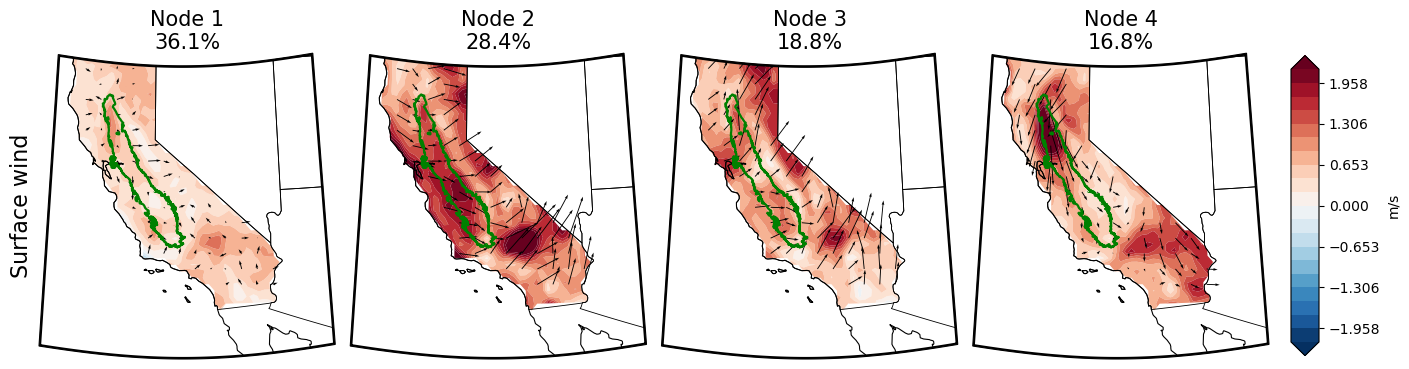

In [12]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib as mpl
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import geopandas as gpd
import regionmask
from cartopy.io import shapereader
from matplotlib.path import Path
from matplotlib.patches import PathPatch
from somoclu import Somoclu

# -------------------- FILES --------------------
Z500_FILE   = "z_dust1.nc"
WS_COMP     = "ason_dusty_wind.nc"
U_COMP      = "ason_dusty_u.nc"
V_COMP      = "ason_dusty_v.nc"
WS_CLIM     = "clim_wind_all.nc"
U_CLIM      = "clim_u_all.nc"
V_CLIM      = "clim_v_all.nc"
CV_SHP      = "central_valley_alluvial_boundary_usgs.shp"

OUT_ANOM    = "node_WIND_ason.png"

# -------------------- DOMAIN / STYLE --------------------
SOM_LON0, SOM_LON1 = -130, -105
SOM_LAT0, SOM_LAT1 =   30,   50
BOX_LON0, BOX_LON1 = -125.0, -112.0
BOX_LAT0, BOX_LAT1 =   31.0,   42.1

SOM_EPOCHS   = 1000
ROB_Q        = 98
QUIVER_STEP  = 3
QUIVER_SCALE = 25

# -------------------- HELPERS --------------------
def tname(ds):
    for k in ("date","time"):
        if k in ds.coords or k in ds.dims: return k
    raise KeyError("No 'valid_time' or 'time' coord.")

def rename_ll(da):
    if "lat" in da.dims: da = da.rename({"lat":"latitude"})
    if "lon" in da.dims: da = da.rename({"lon":"longitude"})
    return da

def fix_lon(da):
    if float(da.longitude.max()) > 180:
        da = da.assign_coords(longitude=((da.longitude+180)%360)-180).sortby("longitude")
    return da

def find_var(ds, candidates):
    for k in candidates:
        if k in ds.data_vars: return k
    for v in ds.data_vars:
        if any(k in v.lower() for k in candidates): return v
    return list(ds.data_vars)[0]

def build_frame(l0,l1,b0,b1, n=200, aT=0.28, aB=0.32):
    f=np.linspace(0,1,n)
    top   = np.c_[np.linspace(l0,l1,n), b1 - aT*np.sin(np.pi*f)]
    right = np.c_[[l1]*n, np.linspace(b1,b0,n)]
    bot   = np.c_[np.linspace(l1,l0,n), b0 - aB*np.sin(np.pi*f)]
    left  = np.c_[[l0]*n, np.linspace(b0,b1,n)]
    pts   = np.vstack([top,right,bot,left,top[:1]])
    codes = [Path.MOVETO] + [Path.LINETO]*(len(pts)-2) + [Path.CLOSEPOLY]
    return Path(pts, codes)

def clip_to_frame(ax, path):
    ax.set_boundary(path, transform=ccrs.PlateCarree())
    ax.patch.set_facecolor("none")
    ax.add_patch(PathPatch(path, transform=ccrs.PlateCarree(),
                           facecolor="none", edgecolor="black",
                           linewidth=3, zorder=10))

def crop_rect(da):
    return da.where((da.latitude>=BOX_LAT0)&(da.latitude<=BOX_LAT1)&
                    (da.longitude>=BOX_LON0)&(da.longitude<=BOX_LON1), drop=True)

def mask_CA(da):
    ne = shapereader.natural_earth("50m","cultural","admin_1_states_provinces")
    states = gpd.read_file(ne).to_crs(4326)
    ca = states.query("name=='California' and adm0_a3=='USA'").geometry.union_all()
    g  = gpd.GeoDataFrame(geometry=[ca.buffer(0.05)], crs=4326)
    m  = regionmask.mask_geopandas(g, da.longitude, da.latitude)
    return da.where(~np.isnan(m)), g   # return the polygon g as well if needed

def md_group_mean(da, t):
    md = xr.DataArray(da[t].dt.strftime("%m-%d").values, dims=[t], name="md")
    return da.groupby(md).mean(t)  # → dim 'md'

def node_mean(da, mask_bool):
    tn = [d for d in da.dims if d in ("time","date")][0]
    idx = np.where(mask_bool)[0]
    if idx.size == 0:
        return np.full((da.sizes["latitude"], da.sizes["longitude"]), np.nan)
    return da.isel({tn: idx}).mean(tn, skipna=True).values

# -------------------- 1) SOM on Z500 --------------------
dsz = xr.open_dataset(Z500_FILE); tz=tname(dsz)
z = rename_ll(fix_lon(dsz["z"]))
if "pressure_level" in z.dims: z = z.sel(pressure_level=500)
z = z.sel({tz: z[tz].dt.month.isin([8,9,10,11])})
z = z.where((z.latitude>=SOM_LAT0)&(z.latitude<=SOM_LAT1)&
            (z.longitude>=SOM_LON0)&(z.longitude<=SOM_LON1), drop=True)

A = z.values; nt, ny, nx = A.shape
som = Somoclu(2,2, maptype="planar", initialization="pca")
np.random.seed(0)
som.train(A.reshape(nt, ny*nx), epochs=SOM_EPOCHS)
labels_all = som.bmus[:,0]*2 + som.bmus[:,1]
times_all  = z[tz].values
freqs = np.array([(labels_all==i).mean()*100 for i in range(4)])
order = np.argsort(-freqs)  # most→least

# -------------------- 2) Load composites/clims --------------------
dsc_ws = xr.open_dataset(WS_COMP); dsc_u = xr.open_dataset(U_COMP); dsc_v = xr.open_dataset(V_COMP)
wsC = rename_ll(fix_lon(dsc_ws[find_var(dsc_ws,["ws","speed","wind","sfcwind","ws10"])]))
uC  = rename_ll(fix_lon(dsc_u[ find_var(dsc_u, ["u10","uas","u"]) ]))
vC  = rename_ll(fix_lon(dsc_v[ find_var(dsc_v, ["v10","vas","v"]) ]))
tc_ws = tname(dsc_ws); tc_u = tname(dsc_u); tc_v = tname(dsc_v)

dsk_ws = xr.open_dataset(WS_CLIM); dsk_u = xr.open_dataset(U_CLIM); dsk_v = xr.open_dataset(V_CLIM)
wsK = rename_ll(fix_lon(dsk_ws[find_var(dsk_ws,["ws","speed","wind","sfcwind","ws10"])]))
uK  = rename_ll(fix_lon(dsk_u[ find_var(dsk_u, ["u10","uas","u"]) ]))
vK  = rename_ll(fix_lon(dsk_v[ find_var(dsk_v, ["v10","vas","v"]) ]))
tk_ws = tname(dsk_ws); tk_u = tname(dsk_u); tk_v = tname(dsk_v)

# Align lon/lat & SON only
wsK, wsC = xr.align(wsK, wsC, join="inner")
uK,  uC  = xr.align(uK,  uC,  join="inner")
vK,  vC  = xr.align(vK,  vC,  join="inner")
wsC = wsC.sel({tc_ws: wsC[tc_ws].dt.month.isin([8,9,10,11])})
uC  = uC.sel({tc_u:  uC[tc_u].dt.month.isin([8,9,10,11])})
vC  = vC.sel({tc_v:  vC[tc_v].dt.month.isin([8,9,10,11])})

# Common times with labels
common = np.intersect1d(np.intersect1d(wsC[tc_ws].values, uC[tc_u].values),
                        np.intersect1d(vC[tc_v].values, times_all))
wsC = wsC.sel({tc_ws: wsC[tc_ws].isin(common)})
uC  = uC.sel({tc_u:  uC[tc_u].isin(common)})
vC  = vC.sel({tc_v:  vC[tc_v].isin(common)})

# Reorder labels to wsC time sequence
labels_lookup = {t: lab for t, lab in zip(times_all, labels_all)}
labels = np.array([labels_lookup[t] for t in wsC[tc_ws].values])

# Shaded wind → CA mask; quiver grid (cropped only)
wsC_sh, g_ca = mask_CA(crop_rect(wsC))
wsK_sh, _    = mask_CA(crop_rect(wsK))
uC_q = crop_rect(uC);  vC_q = crop_rect(vC)
uK_q = crop_rect(uK);  vK_q = crop_rect(vK)

# Build CA mask ON THE QUIVER GRID and keep as boolean
ca_mask_q = regionmask.mask_geopandas(g_ca, uC_q.longitude, uC_q.latitude)
inside_q = ~np.isnan(ca_mask_q)  # True inside California polygon

# Climatology by month–day
clim_md_ws_sh = md_group_mean(wsK_sh, tk_ws)
clim_md_u_q   = md_group_mean(uK_q,  tk_u)
clim_md_v_q   = md_group_mean(vK_q,  tk_v)
md_all = wsC[tc_ws].dt.strftime("%m-%d").values

# -------------------- 3) Node ANOMALIES --------------------
ny, nx  = wsC_sh.sizes["latitude"], wsC_sh.sizes["longitude"]
nyq, nxq = uC_q.sizes["latitude"],  uC_q.sizes["longitude"]

ws_anom_nodes, u_anom_q_nodes, v_anom_q_nodes = [], [], []
for n in range(4):
    m = (labels == n)
    md_n = md_all[m]
    if md_n.size == 0:
        ws_anom_nodes.append(np.full((ny,nx), np.nan))
        u_anom_q_nodes.append(np.full((nyq,nxq), np.nan))
        v_anom_q_nodes.append(np.full((nyq,nxq), np.nan))
        continue

    ws_mean_n = node_mean(wsC_sh, m)
    ws_clim_n = clim_md_ws_sh.sel(md=md_n).mean("md", skipna=True).values
    ws_anom_nodes.append(ws_mean_n - ws_clim_n)

    u_mean_q = node_mean(uC_q, m)
    v_mean_q = node_mean(vC_q, m)
    u_cl = clim_md_u_q.sel(md=md_n).mean("md", skipna=True).values
    v_cl = clim_md_v_q.sel(md=md_n).mean("md", skipna=True).values
    u_anom_q_nodes.append(u_mean_q - u_cl)
    v_anom_q_nodes.append(v_mean_q - v_cl)

# Order by frequency
order = np.argsort(-freqs)
freq_sorted    = [freqs[i]            for i in order]
ws_anom_sorted = [ws_anom_nodes[i]    for i in order]
u_anom_sorted  = [u_anom_q_nodes[i]   for i in order]
v_anom_sorted  = [v_anom_q_nodes[i]   for i in order]

# Grids
LON_sh, LAT_sh = np.meshgrid(wsC_sh.longitude.values, wsC_sh.latitude.values)
LON_q,  LAT_q  = np.meshgrid(uC_q.longitude.values,  uC_q.latitude.values)

# -------------------- 4) PLOT: ANOMALY ONLY, QUIVERS INSIDE CA --------------------
cv_gdf = gpd.read_file(CV_SHP).to_crs(4326)
frame = build_frame(BOX_LON0,BOX_LON1,BOX_LAT0,BOX_LAT1)
proj = ccrs.LambertConformal(central_longitude=-119, central_latitude=37,
                             standard_parallels=(33,45))

fig, axes = plt.subplots(1,4, figsize=(14,6), subplot_kw={"projection": proj})
plt.tight_layout(rect=[0.08,0.02,0.98,1.00])

arr = np.stack(ws_anom_sorted, axis=0)
rob  = np.nanpercentile(np.abs(arr), ROB_Q)
vlim = float(max(rob, 0.5))
levels = np.linspace(-vlim, vlim, 21)
cmap = mpl.colormaps["RdBu_r"].copy()
cmap.set_bad(cmap(0)); cmap.set_under(cmap(0))
cf_last = None

for i, ax in enumerate(axes):
    clip_to_frame(ax, frame)
    ax.set_extent([BOX_LON0, BOX_LON1, BOX_LAT0, BOX_LAT1], crs=ccrs.PlateCarree())

    # shaded anomalies (masked to CA)
    cf_last = ax.contourf(LON_sh, LAT_sh, np.ma.masked_invalid(ws_anom_sorted[i]),
                          levels=levels, cmap=cmap, extend="both",
                          transform=ccrs.PlateCarree(), antialiased=True)

    # --- quivers: HARD MASK outside CA (set NaN) ---
    U = u_anom_sorted[i].copy()
    V = v_anom_sorted[i].copy()
    # mask outside CA or non-finite values
    outside = (~inside_q.values) | (~np.isfinite(U)) | (~np.isfinite(V))
    U[outside] = np.nan
    V[outside] = np.nan

    Uq = U[::QUIVER_STEP, ::QUIVER_STEP]
    Vq = V[::QUIVER_STEP, ::QUIVER_STEP]
    Xq = LON_q[::QUIVER_STEP, ::QUIVER_STEP]
    Yq = LAT_q[::QUIVER_STEP, ::QUIVER_STEP]

    ax.quiver(Xq, Yq, Uq, Vq, transform=ccrs.PlateCarree(),
              scale=QUIVER_SCALE, width=0.003, regrid_shape=20, zorder=7)

    ax.add_feature(cfeature.COASTLINE.with_scale("50m"), linewidth=0.8, zorder=6)
    ax.add_feature(cfeature.STATES.with_scale("50m"),  linewidth=0.6, zorder=6)
    ax.add_geometries(cv_gdf.geometry, crs=ccrs.PlateCarree(),
                      edgecolor="green", facecolor="none", linewidth=1.6, zorder=8)
    ax.set_title(f"Node {i+1}\n{freq_sorted[i]:.1f}%", fontsize=15, pad=3)

fig.supylabel("Surface wind", x=0.07, fontsize=16)
cax = fig.add_axes([0.985, 0.25, 0.02, 0.5])
cb  = fig.colorbar(cf_last, cax=cax, orientation="vertical")
cb.set_label("m/s")
fig.savefig(OUT_ANOM, dpi=500, bbox_inches="tight")
plt.show()


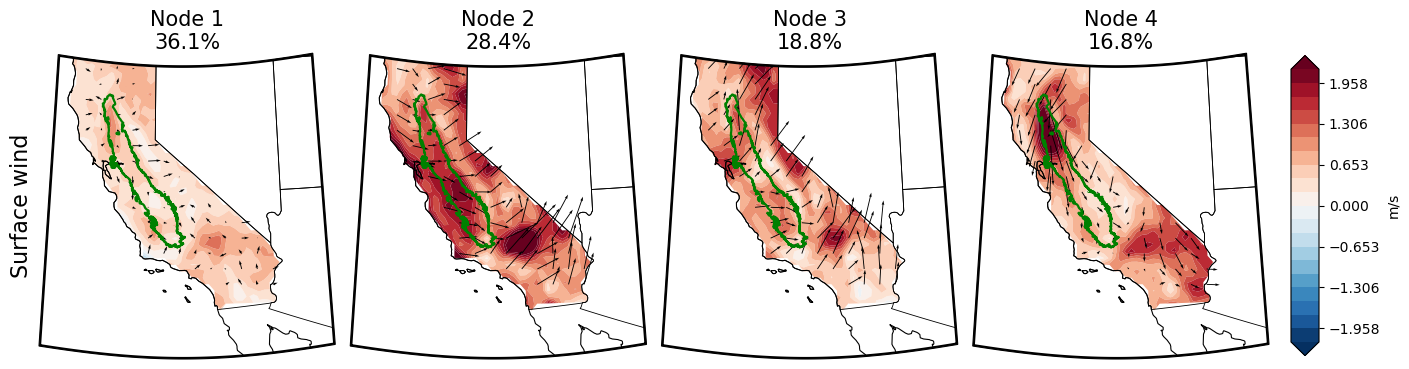

In [13]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib as mpl
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import geopandas as gpd
import regionmask
from cartopy.io import shapereader
from matplotlib.path import Path
from matplotlib.patches import PathPatch
from somoclu import Somoclu

# -------------------- FILES --------------------
Z500_FILE   = "z_dust1.nc"
WS_COMP     = "ason_dusty_wind.nc"
U_COMP      = "ason_dusty_u.nc"
V_COMP      = "ason_dusty_v.nc"
WS_CLIM     = "ason_clim_wind_all.nc"
U_CLIM      = "ason_clim_u_all.nc"
V_CLIM      = "ason_clim_v_all.nc"
CV_SHP      = "central_valley_alluvial_boundary_usgs.shp"

OUT_ANOM    = "node_WIND_ason2.png"

# -------------------- DOMAIN / STYLE --------------------
SOM_LON0, SOM_LON1 = -130, -105
SOM_LAT0, SOM_LAT1 =   30,   50
BOX_LON0, BOX_LON1 = -125.0, -112.0
BOX_LAT0, BOX_LAT1 =   31.0,   42.1

SOM_EPOCHS   = 1000
ROB_Q        = 98
QUIVER_STEP  = 3
QUIVER_SCALE = 25

# -------------------- HELPERS --------------------
def tname(ds):
    for k in ("date","time"):
        if k in ds.coords or k in ds.dims: return k
    raise KeyError("No 'valid_time' or 'time' coord.")

def rename_ll(da):
    if "lat" in da.dims: da = da.rename({"lat":"latitude"})
    if "lon" in da.dims: da = da.rename({"lon":"longitude"})
    return da

def fix_lon(da):
    if float(da.longitude.max()) > 180:
        da = da.assign_coords(longitude=((da.longitude+180)%360)-180).sortby("longitude")
    return da

def find_var(ds, candidates):
    for k in candidates:
        if k in ds.data_vars: return k
    for v in ds.data_vars:
        if any(k in v.lower() for k in candidates): return v
    return list(ds.data_vars)[0]

def build_frame(l0,l1,b0,b1, n=200, aT=0.28, aB=0.32):
    f=np.linspace(0,1,n)
    top   = np.c_[np.linspace(l0,l1,n), b1 - aT*np.sin(np.pi*f)]
    right = np.c_[[l1]*n, np.linspace(b1,b0,n)]
    bot   = np.c_[np.linspace(l1,l0,n), b0 - aB*np.sin(np.pi*f)]
    left  = np.c_[[l0]*n, np.linspace(b0,b1,n)]
    pts   = np.vstack([top,right,bot,left,top[:1]])
    codes = [Path.MOVETO] + [Path.LINETO]*(len(pts)-2) + [Path.CLOSEPOLY]
    return Path(pts, codes)

def clip_to_frame(ax, path):
    ax.set_boundary(path, transform=ccrs.PlateCarree())
    ax.patch.set_facecolor("none")
    ax.add_patch(PathPatch(path, transform=ccrs.PlateCarree(),
                           facecolor="none", edgecolor="black",
                           linewidth=3, zorder=10))

def crop_rect(da):
    return da.where((da.latitude>=BOX_LAT0)&(da.latitude<=BOX_LAT1)&
                    (da.longitude>=BOX_LON0)&(da.longitude<=BOX_LON1), drop=True)

def mask_CA(da):
    ne = shapereader.natural_earth("50m","cultural","admin_1_states_provinces")
    states = gpd.read_file(ne).to_crs(4326)
    ca = states.query("name=='California' and adm0_a3=='USA'").geometry.union_all()
    g  = gpd.GeoDataFrame(geometry=[ca.buffer(0.05)], crs=4326)
    m  = regionmask.mask_geopandas(g, da.longitude, da.latitude)
    return da.where(~np.isnan(m)), g   # return the polygon g as well if needed

def md_group_mean(da, t):
    md = xr.DataArray(da[t].dt.strftime("%m-%d").values, dims=[t], name="md")
    return da.groupby(md).mean(t)  # → dim 'md'

def node_mean(da, mask_bool):
    tn = [d for d in da.dims if d in ("time","date")][0]
    idx = np.where(mask_bool)[0]
    if idx.size == 0:
        return np.full((da.sizes["latitude"], da.sizes["longitude"]), np.nan)
    return da.isel({tn: idx}).mean(tn, skipna=True).values

# -------------------- 1) SOM on Z500 --------------------
dsz = xr.open_dataset(Z500_FILE); tz=tname(dsz)
z = rename_ll(fix_lon(dsz["z"]))
if "pressure_level" in z.dims: z = z.sel(pressure_level=500)
z = z.sel({tz: z[tz].dt.month.isin([8,9,10,11])})
z = z.where((z.latitude>=SOM_LAT0)&(z.latitude<=SOM_LAT1)&
            (z.longitude>=SOM_LON0)&(z.longitude<=SOM_LON1), drop=True)

A = z.values; nt, ny, nx = A.shape
som = Somoclu(2,2, maptype="planar", initialization="pca")
np.random.seed(0)
som.train(A.reshape(nt, ny*nx), epochs=SOM_EPOCHS)
labels_all = som.bmus[:,0]*2 + som.bmus[:,1]
times_all  = z[tz].values
freqs = np.array([(labels_all==i).mean()*100 for i in range(4)])
order = np.argsort(-freqs)  # most→least

# -------------------- 2) Load composites/clims --------------------
dsc_ws = xr.open_dataset(WS_COMP); dsc_u = xr.open_dataset(U_COMP); dsc_v = xr.open_dataset(V_COMP)
wsC = rename_ll(fix_lon(dsc_ws[find_var(dsc_ws,["ws","speed","wind","sfcwind","ws10"])]))
uC  = rename_ll(fix_lon(dsc_u[ find_var(dsc_u, ["u10","uas","u"]) ]))
vC  = rename_ll(fix_lon(dsc_v[ find_var(dsc_v, ["v10","vas","v"]) ]))
tc_ws = tname(dsc_ws); tc_u = tname(dsc_u); tc_v = tname(dsc_v)

dsk_ws = xr.open_dataset(WS_CLIM); dsk_u = xr.open_dataset(U_CLIM); dsk_v = xr.open_dataset(V_CLIM)
wsK = rename_ll(fix_lon(dsk_ws[find_var(dsk_ws,["ws","speed","wind","sfcwind","ws10"])]))
uK  = rename_ll(fix_lon(dsk_u[ find_var(dsk_u, ["u10","uas","u"]) ]))
vK  = rename_ll(fix_lon(dsk_v[ find_var(dsk_v, ["v10","vas","v"]) ]))
tk_ws = tname(dsk_ws); tk_u = tname(dsk_u); tk_v = tname(dsk_v)

# Align lon/lat & SON only
wsK, wsC = xr.align(wsK, wsC, join="inner")
uK,  uC  = xr.align(uK,  uC,  join="inner")
vK,  vC  = xr.align(vK,  vC,  join="inner")
wsC = wsC.sel({tc_ws: wsC[tc_ws].dt.month.isin([8,9,10,11])})
uC  = uC.sel({tc_u:  uC[tc_u].dt.month.isin([8,9,10,11])})
vC  = vC.sel({tc_v:  vC[tc_v].dt.month.isin([8,9,10,11])})

# Common times with labels
common = np.intersect1d(np.intersect1d(wsC[tc_ws].values, uC[tc_u].values),
                        np.intersect1d(vC[tc_v].values, times_all))
wsC = wsC.sel({tc_ws: wsC[tc_ws].isin(common)})
uC  = uC.sel({tc_u:  uC[tc_u].isin(common)})
vC  = vC.sel({tc_v:  vC[tc_v].isin(common)})

# Reorder labels to wsC time sequence
labels_lookup = {t: lab for t, lab in zip(times_all, labels_all)}
labels = np.array([labels_lookup[t] for t in wsC[tc_ws].values])

# Shaded wind → CA mask; quiver grid (cropped only)
wsC_sh, g_ca = mask_CA(crop_rect(wsC))
wsK_sh, _    = mask_CA(crop_rect(wsK))
uC_q = crop_rect(uC);  vC_q = crop_rect(vC)
uK_q = crop_rect(uK);  vK_q = crop_rect(vK)

# Build CA mask ON THE QUIVER GRID and keep as boolean
ca_mask_q = regionmask.mask_geopandas(g_ca, uC_q.longitude, uC_q.latitude)
inside_q = ~np.isnan(ca_mask_q)  # True inside California polygon

# Climatology by month–day
clim_md_ws_sh = md_group_mean(wsK_sh, tk_ws)
clim_md_u_q   = md_group_mean(uK_q,  tk_u)
clim_md_v_q   = md_group_mean(vK_q,  tk_v)
md_all = wsC[tc_ws].dt.strftime("%m-%d").values

# -------------------- 3) Node ANOMALIES --------------------
ny, nx  = wsC_sh.sizes["latitude"], wsC_sh.sizes["longitude"]
nyq, nxq = uC_q.sizes["latitude"],  uC_q.sizes["longitude"]

ws_anom_nodes, u_anom_q_nodes, v_anom_q_nodes = [], [], []
for n in range(4):
    m = (labels == n)
    md_n = md_all[m]
    if md_n.size == 0:
        ws_anom_nodes.append(np.full((ny,nx), np.nan))
        u_anom_q_nodes.append(np.full((nyq,nxq), np.nan))
        v_anom_q_nodes.append(np.full((nyq,nxq), np.nan))
        continue

    ws_mean_n = node_mean(wsC_sh, m)
    ws_clim_n = clim_md_ws_sh.sel(md=md_n).mean("md", skipna=True).values
    ws_anom_nodes.append(ws_mean_n - ws_clim_n)

    u_mean_q = node_mean(uC_q, m)
    v_mean_q = node_mean(vC_q, m)
    u_cl = clim_md_u_q.sel(md=md_n).mean("md", skipna=True).values
    v_cl = clim_md_v_q.sel(md=md_n).mean("md", skipna=True).values
    u_anom_q_nodes.append(u_mean_q - u_cl)
    v_anom_q_nodes.append(v_mean_q - v_cl)

# Order by frequency
order = np.argsort(-freqs)
freq_sorted    = [freqs[i]            for i in order]
ws_anom_sorted = [ws_anom_nodes[i]    for i in order]
u_anom_sorted  = [u_anom_q_nodes[i]   for i in order]
v_anom_sorted  = [v_anom_q_nodes[i]   for i in order]

# Grids
LON_sh, LAT_sh = np.meshgrid(wsC_sh.longitude.values, wsC_sh.latitude.values)
LON_q,  LAT_q  = np.meshgrid(uC_q.longitude.values,  uC_q.latitude.values)

# -------------------- 4) PLOT: ANOMALY ONLY, QUIVERS INSIDE CA --------------------
cv_gdf = gpd.read_file(CV_SHP).to_crs(4326)
frame = build_frame(BOX_LON0,BOX_LON1,BOX_LAT0,BOX_LAT1)
proj = ccrs.LambertConformal(central_longitude=-119, central_latitude=37,
                             standard_parallels=(33,45))

fig, axes = plt.subplots(1,4, figsize=(14,6), subplot_kw={"projection": proj})
plt.tight_layout(rect=[0.08,0.02,0.98,1.00])

arr = np.stack(ws_anom_sorted, axis=0)
rob  = np.nanpercentile(np.abs(arr), ROB_Q)
vlim = float(max(rob, 0.5))
levels = np.linspace(-vlim, vlim, 21)
cmap = mpl.colormaps["RdBu_r"].copy()
cmap.set_bad(cmap(0)); cmap.set_under(cmap(0))
cf_last = None

for i, ax in enumerate(axes):
    clip_to_frame(ax, frame)
    ax.set_extent([BOX_LON0, BOX_LON1, BOX_LAT0, BOX_LAT1], crs=ccrs.PlateCarree())

    # shaded anomalies (masked to CA)
    cf_last = ax.contourf(LON_sh, LAT_sh, np.ma.masked_invalid(ws_anom_sorted[i]),
                          levels=levels, cmap=cmap, extend="both",
                          transform=ccrs.PlateCarree(), antialiased=True)

    # --- quivers: HARD MASK outside CA (set NaN) ---
    U = u_anom_sorted[i].copy()
    V = v_anom_sorted[i].copy()
    # mask outside CA or non-finite values
    outside = (~inside_q.values) | (~np.isfinite(U)) | (~np.isfinite(V))
    U[outside] = np.nan
    V[outside] = np.nan

    Uq = U[::QUIVER_STEP, ::QUIVER_STEP]
    Vq = V[::QUIVER_STEP, ::QUIVER_STEP]
    Xq = LON_q[::QUIVER_STEP, ::QUIVER_STEP]
    Yq = LAT_q[::QUIVER_STEP, ::QUIVER_STEP]

    ax.quiver(Xq, Yq, Uq, Vq, transform=ccrs.PlateCarree(),
              scale=QUIVER_SCALE, width=0.003, regrid_shape=20, zorder=7)

    ax.add_feature(cfeature.COASTLINE.with_scale("50m"), linewidth=0.8, zorder=6)
    ax.add_feature(cfeature.STATES.with_scale("50m"),  linewidth=0.6, zorder=6)
    ax.add_geometries(cv_gdf.geometry, crs=ccrs.PlateCarree(),
                      edgecolor="green", facecolor="none", linewidth=1.6, zorder=8)
    ax.set_title(f"Node {i+1}\n{freq_sorted[i]:.1f}%", fontsize=15, pad=3)

fig.supylabel("Surface wind", x=0.07, fontsize=16)
cax = fig.add_axes([0.985, 0.25, 0.02, 0.5])
cb  = fig.colorbar(cf_last, cax=cax, orientation="vertical")
cb.set_label("m/s")
fig.savefig(OUT_ANOM, dpi=500, bbox_inches="tight")
plt.show()


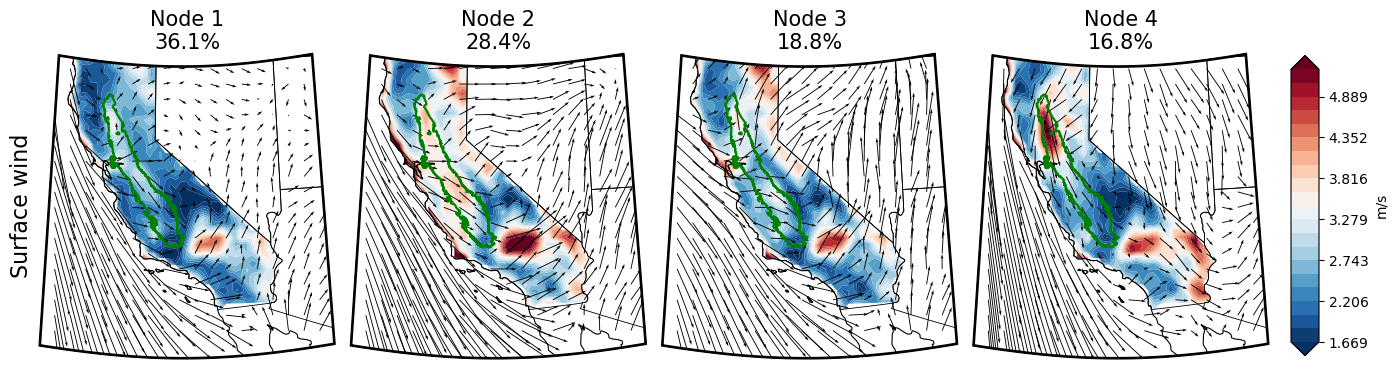

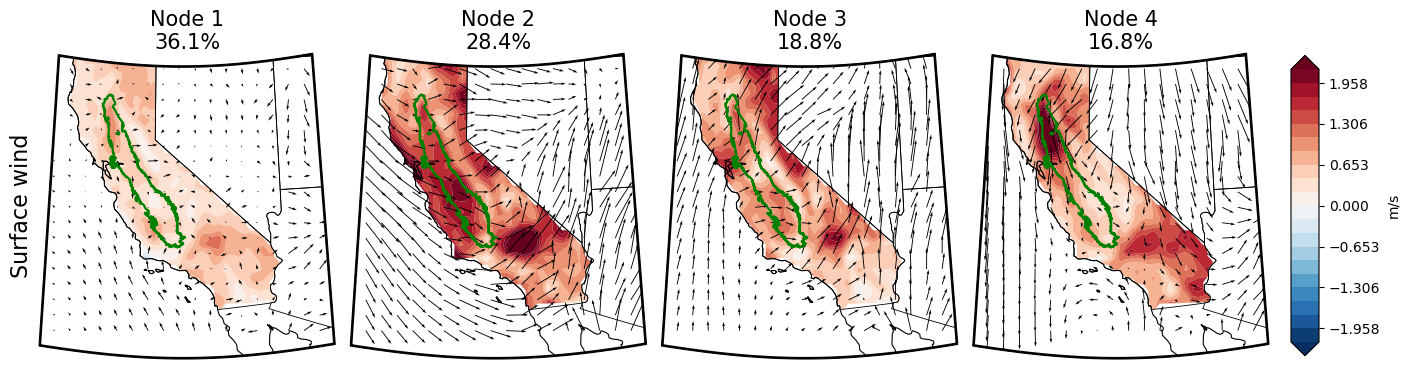

In [14]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib as mpl
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import geopandas as gpd
import regionmask
from cartopy.io import shapereader
from matplotlib.path import Path
from matplotlib.patches import PathPatch
from somoclu import Somoclu


#Z500_FILE   = "z_dust1.nc"
#WS_COMP     = "son_dusty_wind.nc"
#U_COMP      = "son_dusty_u.nc"
#V_COMP      = "son_dusty_v.nc"
#WS_CLIM     = "clim_wind.nc"
#U_CLIM      = "clim_u.nc"
#V_CLIM      = "clim_v.nc"
#CV_SHP      = "central_valley_alluvial_boundary_usgs.shp"


# -------------------- FILES --------------------
Z500_FILE   = "z_dust1.nc"
WS_COMP     = "ason_dusty_wind.nc"
U_COMP      = "ason_dusty_u.nc"
V_COMP      = "ason_dusty_v.nc"
WS_CLIM     = "ason_clim_wind_all.nc"
U_CLIM      = "ason_clim_u_all.nc"
V_CLIM      = "ason_clim_v_all.nc"
CV_SHP      = "central_valley_alluvial_boundary_usgs.shp"

# ===================== FILES =====================
#Z500_FILE   = "z_dust1.nc"
#WS_COMP     = "son_dusty.nc"
#U_COMP      = "u_son_dusty.nc"
#V_COMP      = "v_son_dusty.nc"
#WS_CLIM     = "clim_wind.nc"
#U_CLIM      = "clim_u.nc"
#V_CLIM      = "clim_v.nc"
#CV_SHP      = "central_valley_alluvial_boundary_usgs.shp"

OUT_MEAN    = "ason_wind_mean_by_node.png"
OUT_ANOM    = "ason_wind_anom_by_node.png"

# ===================== DOMAINS/STYLE =====================
SOM_LON0, SOM_LON1 = -130, -105
SOM_LAT0, SOM_LAT1 =   30,   50

BOX_LON0, BOX_LON1 = -125.0, -112.0
BOX_LAT0, BOX_LAT1 =   31.0,   42.1

SOM_EPOCHS   = 1000
ROB_Q        = 98
QUIVER_STEP  = 3
QUIVER_SCALE = 30

# ===================== HELPERS =====================
def tname(ds):
    for k in ("date","time"):
        if k in ds.coords or k in ds.dims: return k
    raise KeyError("No 'valid_time' or 'date' coord.")

def rename_ll(da):
    if "lat" in da.dims: da = da.rename({"lat":"latitude"})
    if "lon" in da.dims: da = da.rename({"lon":"longitude"})
    return da

def fix_lon(da):
    if float(da.longitude.max()) > 180:
        da = da.assign_coords(longitude=((da.longitude+180)%360)-180).sortby("longitude")
    return da

def find_var(ds, candidates):
    for k in candidates:
        if k in ds.data_vars: return k
    for v in ds.data_vars:
        if any(k in v.lower() for k in candidates): return v
    return list(ds.data_vars)[0]

def build_frame(l0,l1,b0,b1, n=200, aT=0.28, aB=0.32):
    f=np.linspace(0,1,n)
    top   = np.c_[np.linspace(l0,l1,n), b1 - aT*np.sin(np.pi*f)]
    right = np.c_[[l1]*n, np.linspace(b1,b0,n)]
    bot   = np.c_[np.linspace(l1,l0,n), b0 - aB*np.sin(np.pi*f)]
    left  = np.c_[[l0]*n, np.linspace(b0,b1,n)]
    pts   = np.vstack([top,right,bot,left,top[:1]])
    codes = [Path.MOVETO] + [Path.LINETO]*(len(pts)-2) + [Path.CLOSEPOLY]
    return Path(pts, codes)

def clip_to_frame(ax, path):
    ax.set_boundary(path, transform=ccrs.PlateCarree())
    ax.patch.set_facecolor("none")
    ax.add_patch(PathPatch(path, transform=ccrs.PlateCarree(),
                           facecolor="none", edgecolor="black",
                           linewidth=3, zorder=10))

def crop_rect(da):
    return da.where((da.latitude>=BOX_LAT0)&(da.latitude<=BOX_LAT1)&
                    (da.longitude>=BOX_LON0)&(da.longitude<=BOX_LON1), drop=True)

def mask_CA(da):
    ne = shapereader.natural_earth("50m","cultural","admin_1_states_provinces")
    states = gpd.read_file(ne).to_crs(4326)
    ca = states.query("name=='California' and adm0_a3=='USA'").geometry.union_all()
    g  = gpd.GeoDataFrame(geometry=[ca.buffer(0.05)], crs=4326)
    m  = regionmask.mask_geopandas(g, da.longitude, da.latitude)
    return da.where(~np.isnan(m))

def monthday_group_mean(da, t):
    md = xr.DataArray(da[t].dt.strftime("%m-%d").values, dims=[t], name="md")
    return da.groupby(md).mean(t)  # → dim 'md'

def node_mean_any(da, mask_bool):
    tn = [d for d in da.dims if d in ("date","date")][0]
    idx = np.where(mask_bool)[0]
    if idx.size == 0:
        return np.full((da.sizes["latitude"], da.sizes["longitude"]), np.nan)
    return da.isel({tn: idx}).mean(tn, skipna=True).values

# ===================== 1) SOM on Z500 =====================
dsz = xr.open_dataset(Z500_FILE); tz=tname(dsz)
z = rename_ll(fix_lon(dsz["z"]))
if "pressure_level" in z.dims: z = z.sel(pressure_level=500)
z = z.sel({tz: z[tz].dt.month.isin([8,9,10,11])})
z = z.where((z.latitude>=SOM_LAT0)&(z.latitude<=SOM_LAT1)&
            (z.longitude>=SOM_LON0)&(z.longitude<=SOM_LON1), drop=True)

A = z.values; nt, ny, nx = A.shape
som = Somoclu(2,2, maptype="planar", initialization="pca")
np.random.seed(0)
som.train(A.reshape(nt, ny*nx), epochs=SOM_EPOCHS)
labels_all = som.bmus[:,0]*2 + som.bmus[:,1]
times_all  = z[tz].values
freqs = np.array([(labels_all==i).mean()*100 for i in range(4)])
order_freq = np.argsort(-freqs)

# ===================== 2) Load ws/u/v + climatologies =====================
dsc_ws = xr.open_dataset(WS_COMP); dsc_u = xr.open_dataset(U_COMP); dsc_v = xr.open_dataset(V_COMP)
wsC = rename_ll(fix_lon(dsc_ws[find_var(dsc_ws,["ws","speed","wind","sfcwind","ws10"])]))
uC  = rename_ll(fix_lon(dsc_u[ find_var(dsc_u, ["u10","uas","u"]) ]))
vC  = rename_ll(fix_lon(dsc_v[ find_var(dsc_v, ["v10","vas","v"]) ]))
tc_ws = tname(dsc_ws); tc_u = tname(dsc_u); tc_v = tname(dsc_v)

dsk_ws = xr.open_dataset(WS_CLIM); dsk_u = xr.open_dataset(U_CLIM); dsk_v = xr.open_dataset(V_CLIM)
wsK = rename_ll(fix_lon(dsk_ws[find_var(dsk_ws,["ws","speed","wind","sfcwind","ws10"])]))
uK  = rename_ll(fix_lon(dsk_u[ find_var(dsk_u, ["u10","uas","u"]) ]))
vK  = rename_ll(fix_lon(dsk_v[ find_var(dsk_v, ["v10","vas","v"]) ]))
tk_ws = tname(dsk_ws); tk_u = tname(dsk_u); tk_v = tname(dsk_v)

# Align lon/lat
wsK, wsC = xr.align(wsK, wsC, join="inner")
uK,  uC  = xr.align(uK,  uC,  join="inner")
vK,  vC  = xr.align(vK,  vC,  join="inner")

# SON only
wsC = wsC.sel({tc_ws: wsC[tc_ws].dt.month.isin([8,9,10,11])})
uC  = uC.sel({tc_u:  uC[tc_u].dt.month.isin([8,9,10,11])})
vC  = vC.sel({tc_v:  vC[tc_v].dt.month.isin([8,9,10,11])})

# Common times with Z500 labels
common = np.intersect1d(np.intersect1d(wsC[tc_ws].values, uC[tc_u].values),
                        np.intersect1d(vC[tc_v].values, times_all))
wsC = wsC.sel({tc_ws: wsC[tc_ws].isin(common)})
uC  = uC.sel({tc_u:  uC[tc_u].isin(common)})
vC  = vC.sel({tc_v:  vC[tc_v].isin(common)})

# Align labels to wsC time order
labels_lookup = {t: lab for t, lab in zip(times_all, labels_all)}
labels = np.array([labels_lookup[t] for t in wsC[tc_ws].values])

# ==== Shaded vs Quiver fields ====
# Shaded wind (both figures use masked shading):
wsC_sh = mask_CA(crop_rect(wsC))
wsK_sh = mask_CA(crop_rect(wsK))

# Quivers:
# - Mean figure: unmasked (cropped only)
# - Anomaly figure: we’ll mask arrows to CA using a mask computed on this grid
uC_q = crop_rect(uC);  vC_q = crop_rect(vC)
uK_q = crop_rect(uK);  vK_q = crop_rect(vK)

# California mask on the QUIVER grid (1 = inside CA)
ne = shapereader.natural_earth("50m","cultural","admin_1_states_provinces")
states = gpd.read_file(ne).to_crs(4326)
ca = states.query("name=='California' and adm0_a3=='USA'").geometry.union_all()
g  = gpd.GeoDataFrame(geometry=[ca.buffer(0.05)], crs=4326)
ca_mask_q = regionmask.mask_geopandas(g, uC_q.longitude, uC_q.latitude)
inside_q = ~np.isnan(ca_mask_q)   # True inside California polygon

# Climatology by month–day
clim_md_ws_sh = monthday_group_mean(wsK_sh, tk_ws)
clim_md_u_q   = monthday_group_mean(uK_q,  tk_u)
clim_md_v_q   = monthday_group_mean(vK_q,  tk_v)
md_all = wsC[tc_ws].dt.strftime("%m-%d").values

# ===================== 3) Node means & anomalies =====================
ny, nx  = wsC_sh.sizes["latitude"], wsC_sh.sizes["longitude"]
nyq, nxq = uC_q.sizes["latitude"],  uC_q.sizes["longitude"]

ws_mean_nodes, ws_anom_nodes = [], []
u_mean_q_nodes, v_mean_q_nodes = [], []
u_anom_q_nodes, v_anom_q_nodes = [], []

for n in range(4):
    m = (labels == n)

    # shaded wind (masked to CA)
    ws_mean_nodes.append(node_mean_any(wsC_sh, m))

    md_n = md_all[m]
    if md_n.size == 0:
        ws_anom_nodes.append(np.full((ny,nx), np.nan))
        u_anom_q_nodes.append(np.full((nyq,nxq), np.nan))
        v_anom_q_nodes.append(np.full((nyq,nxq), np.nan))
    else:
        ws_clim_n = clim_md_ws_sh.sel(md=md_n).mean("md", skipna=True).values
        ws_anom_nodes.append(ws_mean_nodes[-1] - ws_clim_n)

        u_cl = clim_md_u_q.sel(md=md_n).mean("md", skipna=True).values
        v_cl = clim_md_v_q.sel(md=md_n).mean("md", skipna=True).values
        # mean on cropped grid (for arrows)
        u_mean_q = node_mean_any(uC_q, m)
        v_mean_q = node_mean_any(vC_q, m)
        u_anom_q_nodes.append(u_mean_q - u_cl)
        v_anom_q_nodes.append(v_mean_q - v_cl)

    # store mean arrows too
    u_mean_q_nodes.append(node_mean_any(uC_q, m))
    v_mean_q_nodes.append(node_mean_any(vC_q, m))

# Order nodes by frequency
order = order_freq
freq_sorted     = [freqs[i]          for i in order]
ws_mean_sorted  = [ws_mean_nodes[i]  for i in order]
ws_anom_sorted  = [ws_anom_nodes[i]  for i in order]
u_mean_sorted_q = [u_mean_q_nodes[i] for i in order]
v_mean_sorted_q = [v_mean_q_nodes[i] for i in order]
u_anom_sorted_q = [u_anom_q_nodes[i] for i in order]
v_anom_sorted_q = [v_anom_q_nodes[i] for i in order]

# Grids
LON_sh, LAT_sh = np.meshgrid(wsC_sh.longitude.values, wsC_sh.latitude.values)   # shaded
LON_q,  LAT_q  = np.meshgrid(uC_q.longitude.values,  uC_q.latitude.values)      # quivers

# ===================== 4) Plot =====================
cv_gdf = gpd.read_file(CV_SHP).to_crs(4326)
frame = build_frame(BOX_LON0,BOX_LON1,BOX_LAT0,BOX_LAT1)
proj = ccrs.LambertConformal(central_longitude=-119, central_latitude=37,
                             standard_parallels=(33,45))

def plot_with_quivers(shaded_list, U_list, V_list, LON_s, LAT_s, title, out_png, is_anom):
    fig, axes = plt.subplots(1,4, figsize=(14,6), subplot_kw={"projection": proj})
    plt.tight_layout(rect=[0.08,0.02,0.98,1.00])

    arr = np.stack(shaded_list, axis=0)
    if is_anom:
        rob = np.nanpercentile(np.abs(arr), ROB_Q)
        vlim = float(max(rob, 0.5))
        levels = np.linspace(-vlim, vlim, 21)
        cmap = mpl.colormaps["RdBu_r"].copy()
        extend = "both"
    else:
        lo, hi = np.nanpercentile(arr, [2,98])
        if not np.isfinite(lo): lo = float(np.nanmin(arr))
        if not np.isfinite(hi): hi = float(np.nanmax(arr))
        if hi <= lo: hi = lo + 1e-6
        levels = np.linspace(lo, hi, 21)
        cmap = mpl.colormaps["RdBu_r"].copy()
        extend = "both"

    cmap.set_bad(cmap(0)); cmap.set_under(cmap(0))
    cf_last = None

    for i, ax in enumerate(axes):
        clip_to_frame(ax, frame)
        ax.set_extent([BOX_LON0, BOX_LON1, BOX_LAT0, BOX_LAT1], crs=ccrs.PlateCarree())

        # shaded wind (masked)
        cf_last = ax.contourf(LON_s, LAT_s, np.ma.masked_invalid(shaded_list[i]),
                              levels=levels, cmap=cmap, extend=extend,
                              transform=ccrs.PlateCarree(), antialiased=True)

        # quivers (mask outside CA only if anomaly plot)
        U = U_list[i]; V = V_list[i]
        base_mask = ~np.isfinite(U) | ~np.isfinite(V)
        if is_anom:
            # add outside-CA mask for anomaly arrows
            base_mask = base_mask | (~inside_q.values)
        Uq = np.ma.masked_array(U, mask=base_mask)[::QUIVER_STEP, ::QUIVER_STEP]
        Vq = np.ma.masked_array(V, mask=base_mask)[::QUIVER_STEP, ::QUIVER_STEP]
        Xq = LON_q[::QUIVER_STEP, ::QUIVER_STEP]
        Yq = LAT_q[::QUIVER_STEP, ::QUIVER_STEP]
        ax.quiver(Xq, Yq, Uq, Vq, transform=ccrs.PlateCarree(),
                  scale=QUIVER_SCALE, width=0.003, regrid_shape=20, zorder=7)

        ax.add_feature(cfeature.COASTLINE.with_scale("50m"), linewidth=0.8, zorder=6)
        ax.add_feature(cfeature.STATES.with_scale("50m"),  linewidth=0.6, zorder=6)
        ax.add_geometries(cv_gdf.geometry, crs=ccrs.PlateCarree(),
                          edgecolor="green", facecolor="none", linewidth=1.6, zorder=8)
        ax.set_title(f"Node {i+1}\n{freq_sorted[i]:.1f}%", fontsize=15, pad=3)

    fig.supylabel(title, x=0.07, fontsize=16)
    cax = fig.add_axes([0.985, 0.25, 0.02, 0.5])
    cb  = fig.colorbar(cf_last, cax=cax, orientation="vertical")
    cb.set_label("m/s")
    fig.savefig(out_png, dpi=500, bbox_inches="tight")
    plt.show()

# (A) MEAN — quivers unmasked (everywhere)
plot_with_quivers(ws_mean_sorted, u_mean_sorted_q, v_mean_sorted_q,
                  LON_sh, LAT_sh, "Surface wind", OUT_MEAN, is_anom=False)

# (B) ANOMALY — quivers masked to California only
plot_with_quivers(ws_anom_sorted, u_anom_sorted_q, v_anom_sorted_q,
                  LON_sh, LAT_sh, "Surface wind", OUT_ANOM, is_anom=True)
